In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, time, math
os.environ["MKL_NUM_THREADS"] = "12" 
os.environ["NUMEXPR_NUM_THREADS"] = "12" 
os.environ["OMP_NUM_THREADS"] = "12" 
import numpy as np
import scipy.stats as st
import torch
from tqdm import tqdm
from getdist import plots, MCSamples
#import pymultinest
#import ultranest
import getdist
import IPython
#import camb

base_dir = "/home/joeadamo/Research/"
sys.path.append(base_dir+"Software/CLASS-PT/")
#sys.path.append("/Users/JoeyA/Research/Software/CLASS-PT/")
from camb import model, initialpower
from classy import Class
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'

sys.path.append(base_dir+'CovNet')
import src.CovaPT as CovaPT
import src as CovNet

<Figure size 432x288 with 0 Axes>

In [2]:
training_dir = base_dir+"CovNet/Data/Training-Set-HighZ-NGC/"
data_dir =  base_dir+"CovNet/Data/"
PCA_dir = base_dir+"CovNet/Data/PCA-Set/"
CovaPT_dir = base_dir+"CovaPT/Data/"
plots_dir = base_dir+"CovNet/Plots/"

In [3]:
cosmo_prior = np.array([[52, 100],     #H0
                        [0.002, 0.3],  #omch2
                        #[0.005, 0.08], #ombh2
                        [0.3, 1.6],    #A / A_planck
                        #[0.9, 1.1],    #ns
                        [1, 4],        #b1
                        [0, 1],        #b2 (gaussian)
                        [0, 1],        #bGamma2 (gaussian)
                        [0, 30],       #c0 (gaussian)
                        [0, 30],       #c2 (gaussian)
                        [0, 5000]      #Pshot (gaussian)
                        ])

As_planck = 3.0448
ns_planck = 0.9649
ombh2_planck = 0.02237

# fiducial taken to be the cosmology used to generate Patchy mocks
#                 omch2,  h,     A,            b1,     b2      bG2, c0,  c2,  Pshot
truth = np.array([0.1184,0.6777,1.*As_planck, 2.,0., 0., 0., 0., 500, 0.])

# Parameters used to generate the fiducial data vector and covariance matrix
# taken by first running a chain with real ngc_z3 data
#truth = np.array([0.1149978, 0.6920868, 2.894525, 2.226, -1.605, -0.297, 0, 0, 5000, 0])

cosmo_best = np.array([70.848,0.1120,0.7573, 2.8213,-0.2566, -0.0442, 12.0884, 4.54, 381.8, 984])

In [4]:
linear_settings = {'output':'mPk',
                   'non linear':'None',
                   'FFTLog mode':'FAST',
                   'cb':'Yes', # use CDM+baryon spectra
                   'Omfid':'0.31', # fiducial Omega_m
                   'YHe':0.2425,
                   #'N_ur':2.0328,
                   #'N_ncdm':1,
                   #'m_ncdm':0.06,
                   #'T_ncdm': 0.71611,
                   'tau_reio':0.052,
                    }

def calc_Om0(chain):
    Omo = (chain[:,1] + ombh2_planck + 0.00064) / (chain[:,0]/100)**2
    return Omo

def calc_sigma8_CAMB(chain):
    sigma8 = np.zeros(chain.shape[0])
    pars = camb.CAMBparams()
    k = np.linspace(0.005, 0.245, 25)
    z = 0.61
    for i in tqdm(range(chain.shape[0])):
        pars.set_cosmology(H0=chain[i,0], ombh2=ombh2_planck, omch2=chain[i,1])
        pars.InitPower.set_params(ns=ns_planck, As=np.exp(chain[i,2]*As_planck)/1e10)
        #Note non-linear corrections couples to smaller scales than you want
        pars.set_matter_power(redshifts=[z], kmax=np.amax(k))
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        # k bins will be interpolated to what we want later, so it's "ok" if this isn't exact
        kh, z1, pk = results.get_matter_power_spectrum(minkh=np.amin(k), maxkh=np.amax(k), npoints = 100)
        sigma8[i] = results.get_sigma8()
        
    return sigma8

def calc_sigma8(chain):
    cosmo = Class()
    sigma8 = np.zeros(len(chain["weight"]))
    z_pk = 0.61
    for i in tqdm(range(len(sigma8))):
        
        cosmo.set({'A_s':np.exp(chain["As"][i]*As_planck)/1e10,
                   'n_s':ns_planck,
                   'omega_b':ombh2_planck,
                   'omega_cdm':chain["omch2"][i],
                   'H0':chain["H0"][i],
                   'z_pk':z_pk
                  })
        #Set additional CLASS-PT settings
        cosmo.set(linear_settings)
        
        sigma8[i] = cosmo.sigma8()
        cosmo.struct_cleanup()
    return sigma8

# Omo_fid = calc_Omo(np.vstack([cosmo_fid, cosmo_fid]))
# sigma8_fid = calc_sigma8(np.vstack([cosmo_fid, cosmo_fid]))
# print(Omo_fid[0,-1], sigma8_fid[0,-1])

In [5]:
def plot_cosmo_contours(sample_list, param_labels, legend_labels, colors, num_plots, fill=True, truth=[]):
    
    truth_dict = {}
    all_names = ["omch2", "h", "As", "b1", "b2", "bG2", "cs0", "cs2", "cbar", "Pshot"]
    
    if len(truth) != 0:
        for name, truth_val in zip(param_labels, truth):
            truth_dict[name] = truth_val
    
    #KDE_settings={'mult_bias_correction_order':2, "boundary_correction_order":2}
    
    labels = param_labels[:num_plots]
    getdist_samples = []
    # loop thru each chain
    for i in range(len(legend_labels)):
        if "weight" in sample_list[i].dtype.names:
            weights = sample_list[i]["weight"].flatten()
            samples = np.zeros((len(weights), num_plots))
            for j in range(num_plots):
                samples[:, j] = np.array(sample_list[i][sample_list[i].dtype.names[j+2]])
            getdist_samples.append(MCSamples(samples=samples, weights=weights, names = labels, labels=labels, settings=KDE_settings, sampler='nested'))
        else:
            samples = np.zeros((len(sample_list[i]["h"]), num_plots))
            for j in range(num_plots):
                samples[:, j] = np.array(sample_list[i][all_names[j]])
            getdist_samples.append(MCSamples(samples=samples, loglikes=sample_list[i]["loglike"], names = labels, labels=labels))
            
    g = plots.get_subplot_plotter()
    g.settings.legend_fontsize = 16
    if len(truth)!=0: g.triangle_plot(getdist_samples, filled=fill, legend_labels=legend_labels,
                                      markers=truth_dict, contour_colors=colors)
    else:             g.triangle_plot(getdist_samples, filled=fill, legend_labels=legend_labels,
                                      contour_colors=colors)
    
    return g
    
def plot_derived_contours(sample_list, legend_labels, colors, fill=True, mark_truth=False, show_bestfit=False, save_file=""):
    labels =  ["\Omega_m", "H_0", "\sigma_8", "\omega_{cdm}"]
    markers = ["o", "v", "+"]
    
    #cosmo_truth = [0.286, 69.21, 0.7365, 0.1149978]
    cosmo_truth = [0.3079, 67.77, 0.8053, 0.1184]
    truth_dict = {}
    for name, truth in zip(labels, cosmo_truth):
        truth_dict[name] = truth

    stats_like = []
    stats_marg = []
    getdist_samples = []
    for i in range(len(legend_labels)):

        if "weight" in sample_list[i].dtype.names:
            samples = np.vstack([sample_list[i]["Omega_0"], sample_list[i]["H0"], sample_list[i]["sigma8"], sample_list[i]["omch2"]]).T
            weights = sample_list[i]["weight"].flatten()
            getdist_samples.append(MCSamples(samples=samples, weights=weights, names = labels, labels=labels, sampler='nested'))
        else:
            samples = np.vstack([sample_list[i]["Omega_m"], sample_list[i]["H0"], sample_list[i]["sigma8"], sample_list[i]["omch2"]]).T
            getdist_samples.append(MCSamples(samples=samples, loglikes=sample_list[i]["loglike"], names = labels, labels=labels))
        #stats.append(getdist_samples[-1].getMargeStats())
        stats_like.append(getdist_samples[-1].getLikeStats())
        stats_marg.append(getdist_samples[-1].getMargeStats())

        
    #stats = getdist_samples[0].getLikeStats()
    g = plots.get_subplot_plotter()
    if mark_truth==True: g.triangle_plot(getdist_samples, filled=fill, contour_colors=colors, legend_labels=legend_labels, legend_loc='upper right',
                                         markers=truth_dict)
    else:                g.triangle_plot(getdist_samples, filled=fill, contour_colors=colors, legend_labels=legend_labels, legend_loc='upper right',
                                        )#markers={stats.names[i].bestfit_sample, stats.names[j].bestfit_sample})
    
    if show_bestfit==True:
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax = g.subplots[i,j]
                if ax != None and i != j:
                    for k in range(len(getdist_samples)):
                        ax.scatter(stats_marg[k].names[j].mean, stats_marg[k].names[i].mean, marker=markers[k], color="black")
                elif ax != None and i == j:
                    for k in range(len(getdist_samples)):
                        bestfit = stats_marg[k].names[j].mean
                        #sigma = abs(bestfit - stats_marg[k].names[j].lower1)
                        sigma = stats_marg[k].names[j].err
                        ax.axvline(bestfit, color=colors[k])
                        if k == 0: ax.axvspan(bestfit-sigma, bestfit+sigma, alpha=0.2, color=colors[k])
    
    if save_file != "":
        print("saving...")
        g.export(save_file, plots_dir) 
                 
    return g

## MontePython Code

In [6]:
# load in / visualize parameter covariance matrix for testing
montepython_dir = base_dir+"CovNet/chains/MontePython/"
def load_chains(prefix, burn_in, names):
    
    all_filenames = next(os.walk(montepython_dir+prefix), (None, None, []))[2]  # [] if no file
    chain_files = []
    for i in range(len(all_filenames)):
        if ".txt" in all_filenames[i]:
            if "._" in all_filenames[i][:2]:
                #chain_files.append(all_filenames[i][2:])
                continue
            else:
                chain_files.append(all_filenames[i])
    chain_files.sort()
                
    chain_combined = np.genfromtxt(montepython_dir+prefix+chain_files[0], names=names)
    chain_combined = chain_combined[burn_in[0]:]
    for i in range(1, len(chain_files)):
        if burn_in[i] != -1:
            chain_sub = np.genfromtxt(montepython_dir+prefix+chain_files[i], names=names)
            chain_sub = chain_sub[burn_in[i]:]
            # combine all chains into one big chain
            chain_combined = np.concatenate((chain_combined, chain_sub))
    return chain_combined

def load_multinest_chains(prefix, burn_in, names):
    chain = np.genfromtxt(montepython_dir+prefix, names=names)
    chain = chain[burn_in:]
    return chain

In [7]:
#prefix="/test-marg/2023-01-27_15000"
#prefix="test-2/2023-02-02_15000"
prefix_1 = "simulated-data/fixed-gaussian/"
prefix_2 = "simulated-data/vary-determinant/"
prefix_3 = "simulated-data/vary-no-determinant/"
#prefix_3 = "simulated-data/vary-no-determinant-mac/"
prefix_4 = "simulated-data/vary-MLP/"
prefix_5 = "simulated-data/vary-MLP-T/"
prefix_7 = "simulated-data/vary-MLP-gaussian/"
prefix_8 = "simulated-data/vary-MLP-T-gaussian/"
prefix_9 = "simulated-data/vary-MLP-small/"
prefix_10 = "simulated-data/vary-MLP-T-01/"
prefix_11 = "simulated-data/vary-MLP-T-001/"
prefix_12 = "simulated-data/vary-MLP-T-0005/"

prefix_full = "simulated-data/fixed-full/"
prefix_100 = "simulated-data/old-data-vector/fixed-100/"
prefix_200 = "simulated-data/old-data-vector/fixed-200/"
prefix_300 = "simulated-data/old-data-vector/fixed-300/"
prefix_400 = "simulated-data/old-data-vector/fixed-400/"

names=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "cs0", "cs2", "Pshot", "b4", "Omega_m", "H0", "sigma8"]
names_MS=["?", "-ln(Z)", "omch2", "h", "As", "b1", "b2", "bG2", "cs0", "cs2", "Pshot", "b4", "Omega_m", "H0", "sigma8"]
names_marg=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "Omega_m", "H0", "sigma8"]
labels =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]

# To find out how many points to remove right now, run ./montpython.py info
burn_in_1 = [16, 36, 27, 40, 31, 20, 24, 43]
burn_in_2 = [97, 170, 76, 124]
#burn_in_3 = [190, 205, 195, 192]
burn_in_3 = [37, -1, 20, 30, 15, 38, 14, 13]
#burn_in_4 = [16, 17, 27, 14, 27, 9, 9, 20]
burn_in_4 = [24, 14, 19, 12, 15, 23, 30, 17]
#burn_in_5 = [28, 20, 24, 23, 27, 12, 22, 21]
burn_in_5 = [28, 20, 19, 23, 23, 25, 35, 31]
burn_in_7 = [8, 15, 19, 28, 25, 14, 14, 27]
burn_in_8 = [26, 21, 21, 34, 18, 18, 22, 18]
burn_in_9 = [49, 22, 35, 18, 19, 26, 24, 25]

#burn_in_10 = [17, 36, 31, 14, 23, 26, 24, 18]
burn_in_10 = [23, 20, 22, 17, 32, 52, 45, 20]
#burn_in_11 = [94, 112, 78, 104]
burn_in_11 = [43, 127, 85, 105, 131]
#burn_in_12 = [82, 117, 95, 96, 88, 100, 121, 87]
burn_in_12 = [29, 13, 24, 17, 25, 27, 24, 18]


# burn_in_full = [10, 17, 20, 14]
burn_in_full = [25, 14, 19, 16]
burn_in_100 = [19, 30, 20, 22]
burn_in_200 = [24, 17, 24, 37]
burn_in_300 = [30, 30, 30, 30]
burn_in_400 = [24, 22, 17, 19]

chain_fixed = load_chains(prefix_1, burn_in_1, names_marg)
chain_det = load_chains(prefix_2, burn_in_2, names_marg)
chain_no_det = load_chains(prefix_3, burn_in_3, names_marg)

chain_MLP = load_chains(prefix_4, burn_in_4, names_marg)
chain_MLP_small = load_chains(prefix_9, burn_in_9, names_marg)
chain_gaussian_MLP = load_chains(prefix_7, burn_in_7, names_marg)

chain_MLP_T = load_chains(prefix_5, burn_in_5, names_marg)
chain_gaussian_MLP_T = load_chains(prefix_8, burn_in_8, names_marg)
chain_MLP_T_01 = load_chains(prefix_10, burn_in_10, names_marg)
chain_MLP_T_001 = load_chains(prefix_11, burn_in_11, names_marg)
chain_MLP_T_0005 = load_chains(prefix_12, burn_in_12, names_marg)

chain_full = load_chains(prefix_full, burn_in_full, names_marg)
chain_100 = load_chains(prefix_100, burn_in_100, names_marg)
chain_200 = load_chains(prefix_200, burn_in_200, names_marg)
chain_300 = load_chains(prefix_300, burn_in_300, names_marg)
chain_400 = load_chains(prefix_400, burn_in_400, names_marg)
# print(chain_400.shape)

print(len(chain_no_det))

72417


## Contour plots

In [43]:
#test that each chain looks good
# for name in chain_no_det.dtype.names:
#     plt.figure()
#     plt.plot(range(chain_no_det.shape[0]), chain_no_det[name])
#     plt.xlabel("N")
#     plt.ylabel(name)

Removed no burn in
Removed no burn in


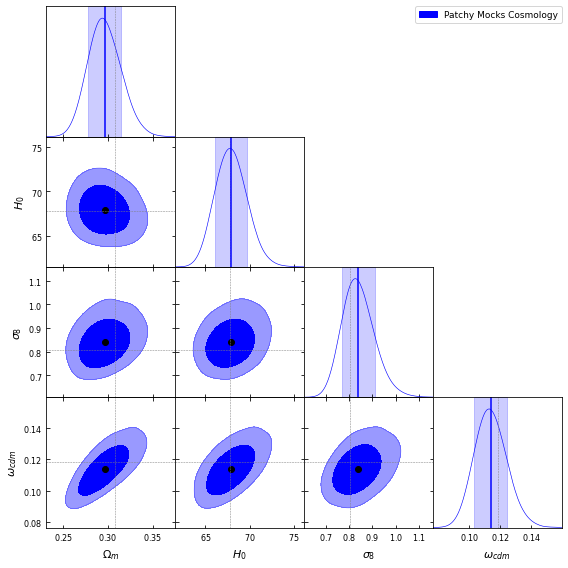

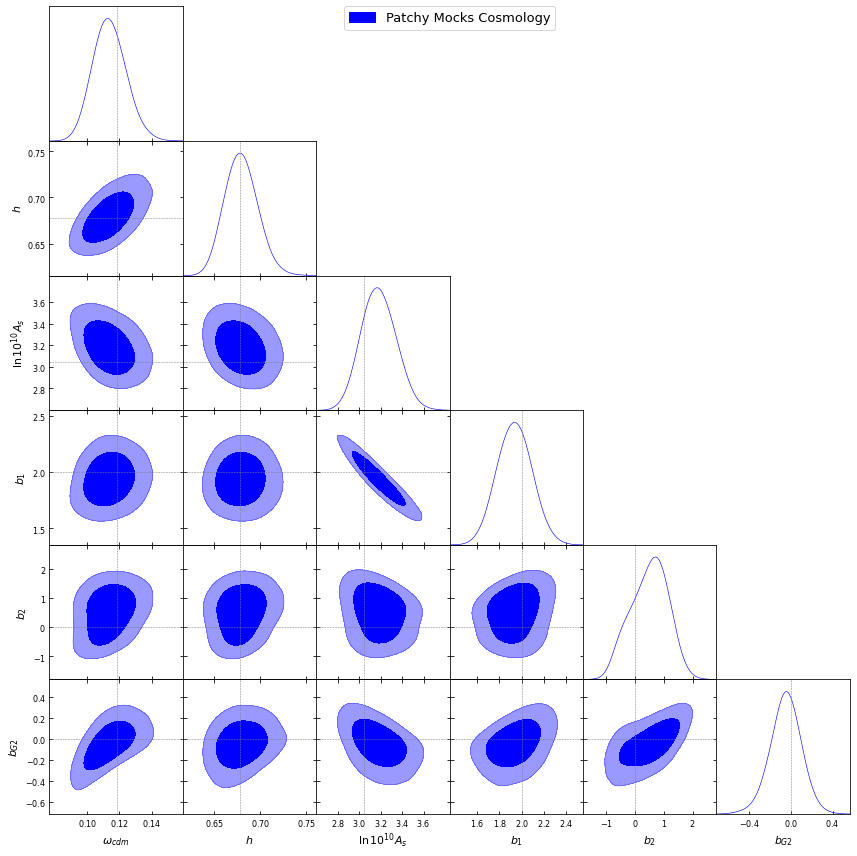

In [8]:
axes = plot_derived_contours([chain_MLP_T_001],
                             [r"Patchy Mocks Cosmology"],
                             ["blue"], [True], True, show_bestfit=True)
plot_cosmo_contours([chain_MLP_T_001], labels,
                    [r"Patchy Mocks Cosmology"],
                    ["blue"], 6, truth=truth, fill=[True])

In [11]:
# axes = plot_derived_contours([chain_full, chain_200, chain_100, chain_300, chain_400],
#                              ["fixed covariance (full)", "fixed covariance (100 PCs)", "fixed covariance (200 PCs)", "fixed covariance (300 PCs)", "fixed covariance (400 PCs)"],
#                              ["gray", "blue", "green", "orange", "red"], [True, False, False, False, False], True)
# plot_cosmo_contours([chain_full, chain_100, chain_200, chain_300, chain_400], labels,
#                     ["fixed covariance (full)", "fixed covariance (100 PCs)", "fixed covariance (200 PCs)", "fixed covariance (300 PCs)", "fixed covariance (400 PCs)"],
#                     ["gray", "blue", "green", "orange", "red"], 6, truth=truth, fill=[True, False, False, False, False])

Removed no burn in
Removed no burn in


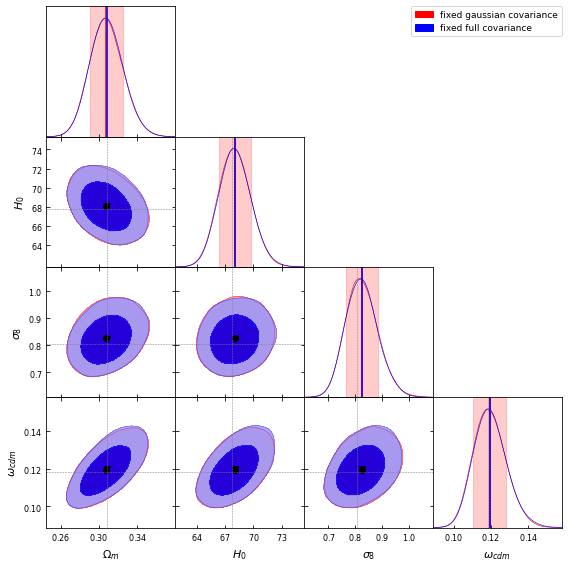

In [12]:
#print(getdist.plots.GetDistPlotSettings())
axes = plot_derived_contours([chain_fixed, chain_full], 
                             ["fixed gaussian covariance", "fixed full covariance"],
                             ["red", "blue"], [True, True], True, True)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


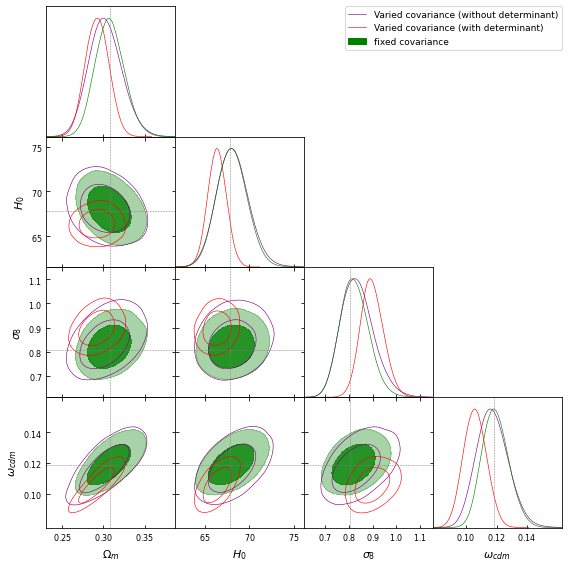

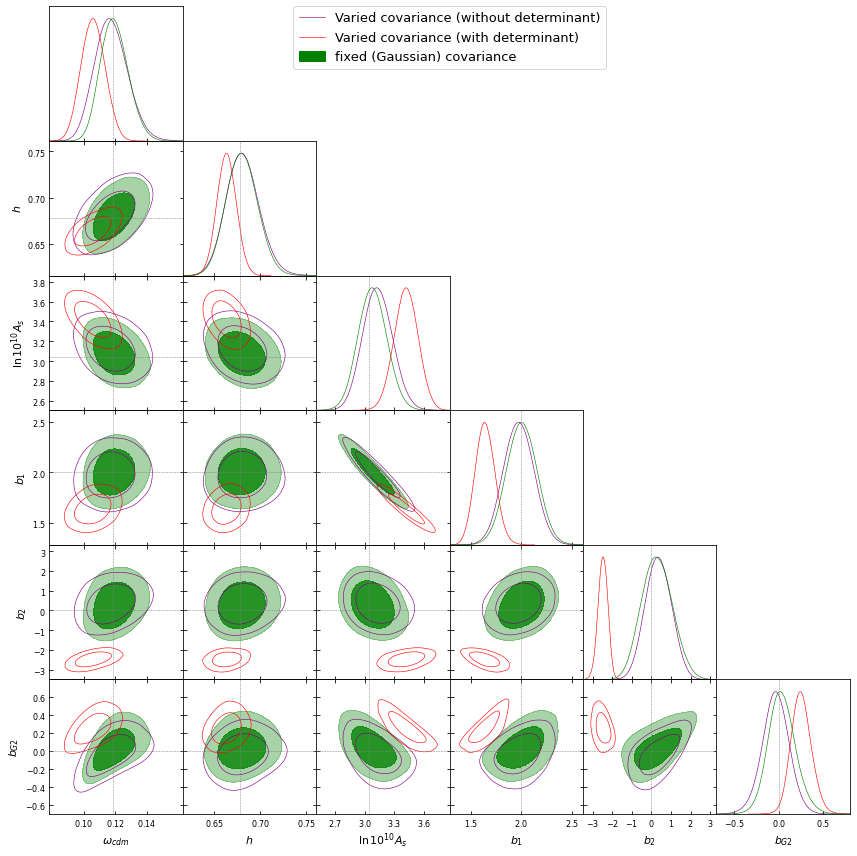

In [13]:
#plot_derived_contours([chain_1, chain_no_det], ["with marginalization (MH)", "without marginalization (Multinest)"], True)
#plot_derived_contours([chain_no_det, chain_1], ["Beutler Data Vector (Misha's Lilelihood)", "Wadekar Data Vector"], True)
#plot_derived_contours([chain_no_det, chain_gaussian], ["Beutler Data Vector (Misha's likelihood)", "Beutler Data Vector (old marginalized likelihood)"], True)
labels =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]

axs = plot_derived_contours([chain_no_det, chain_det, chain_fixed], 
                      ["Varied covariance (without determinant)", "Varied covariance (with determinant)", "fixed covariance"], 
                      ["purple", "red", "green"], [False, False, True], True, False, "Determinant-contours.pdf")

axs = plot_cosmo_contours([chain_no_det, chain_det, chain_fixed], labels,
                      ["Varied covariance (without determinant)", "Varied covariance (with determinant)", "fixed (Gaussian) covariance"],
                      ["purple", "red", "green"], 6, truth=truth, fill=[False, False, True])

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


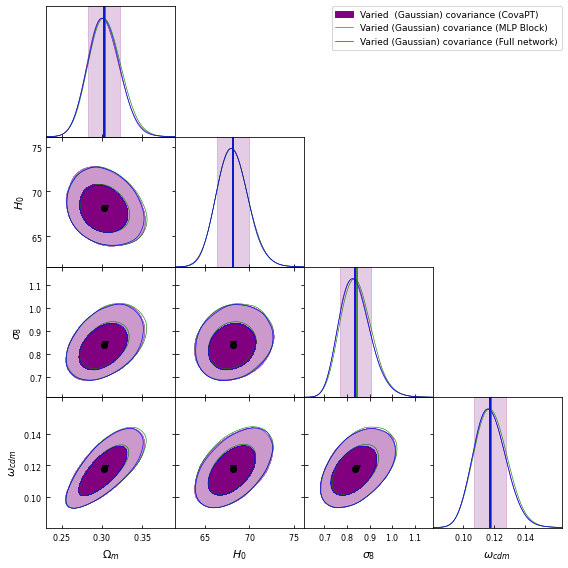

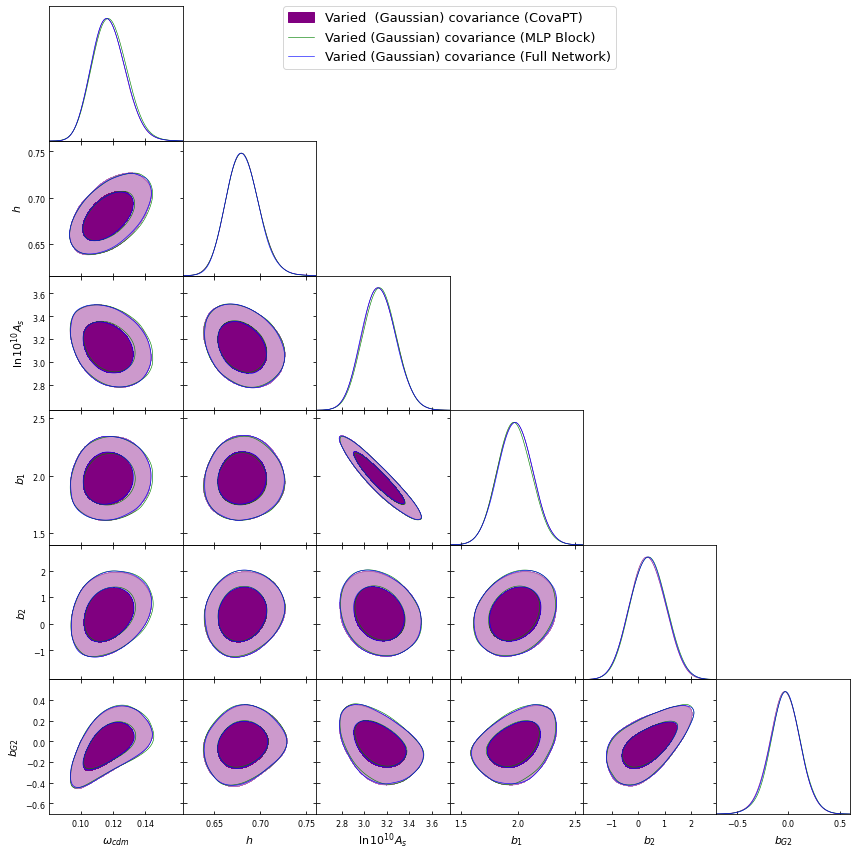

In [14]:
#plot_cosmo_contours([chain_gaussian, chain_1], labels, ["Beutler Data Vector", "Montepython Data Vector"],6, truth=[], fill=True)
#plot_cosmo_contours([chain_no_det, chain_1], labels, ["Beutler Data Vector (Misha's Likelihood)", "Wadekar Data Vector"], 6, truth=[], fill=True)
#plot_cosmo_contours([chain_no_det, chain_gaussian], labels, ["Beutler Data Vector (Misha's likelihood)", "Beutler Data Vector (old marginalized likelihood)"], 6, truth=[], fill=True)

axs = plot_derived_contours([chain_no_det, chain_gaussian_MLP, chain_gaussian_MLP_T],
                      ["Varied  (Gaussian) covariance (CovaPT)", "Varied (Gaussian) covariance (MLP Block)", "Varied (Gaussian) covariance (Full network)"], 
                      ["purple", "green", "blue", "purple"], [True, False, False], False, True,  "Gaussian-Test.pdf")

axs = plot_cosmo_contours([chain_no_det, chain_gaussian_MLP, chain_gaussian_MLP_T], labels,
                      ["Varied  (Gaussian) covariance (CovaPT)", "Varied (Gaussian) covariance (MLP Block)", "Varied (Gaussian) covariance (Full Network)"], 
                      ["purple", "green", "blue", "purple"], 6, truth=[], fill=[True, False, False])
# axs = plot_derived_contours([chain_gaussian, chain_gaussian_MLP, chain_gaussian_VAE, chain_gaussian_AE],
#                       ["Varied  (Gaussian) covariance (CovaPT)", "Varied (Gaussian) covariance (MLP emulator)", "Varied (Gaussian) covariance (VAE emulator)", "Varied (Gaussian) covariance (AE emulator)"], 
#                       ["red", "green", "blue", "purple"], [True, False, False, False], False)

# axs = plot_cosmo_contours([chain_gaussian, chain_gaussian_MLP, chain_gaussian_VAE, chain_gaussian_AE], labels,
#                       ["Varied  (Gaussian) covariance (CovaPT)", "Varied (Gaussian) covariance (MLP emulator)", "Varied (Gaussian) covariance (VAE emulator)", "Varied (Gaussian) covariance (AE emulator)"], 
#                       ["red", "green", "blue", "purple"], 6, truth=[], fill=[True, False, False, False])

In [10]:
# save the varied gaussian covariance term multiplied by a "Temperature" of 1.2 to be used in the
# performace sampling test

V1 = 1; V2 = 1
for i in range(2, len(chain_det.dtype.names)-3):
    name_2 = chain_det.dtype.names[i]
    name_3 = chain_no_det.dtype.names[i]
    V1*= (np.amax(chain_det[name_2]) - np.amin(chain_det[name_2]))
    V2*= (np.amax(chain_no_det[name_3]) - np.amin(chain_no_det[name_3]))

print("V1 = {:0.3f}, V2 = {:0.3f}, ratio = {:0.4f}".format(V1, V2, V1/V2))
    
chain_importance = np.zeros((len(chain_no_det.dtype.names)-2, chain_no_det.shape[0]))
T_value = 1.0

# for i in range(2, len(chain_no_det.dtype.names)):
#     idx = i-2
#     name = chain_no_det.dtype.names[i]
#     # apply the tempterature
#     chain_importance[idx, :] = T_value * (chain_no_det[name] - np.mean(chain_no_det[name])) + np.mean(chain_no_det[name])

#     plt.figure()
#     plt.plot(range(chain_importance.shape[1]), chain_importance[idx,:], alpha=0.5, label="temp applied")
#     plt.plot(range(chain_no_det.shape[0]), chain_no_det[name], alpha=0.5, label="no temp applied")
#     plt.xlabel("N")
#     plt.ylabel(name)
#     plt.legend()

V1 = 0.006, V2 = 0.251, ratio = 0.0233


In [11]:
header_str = "H0\t omch2\t A\t b1\t b2\t bG2"
save_data = np.vstack((chain_importance[1,:]*100., chain_importance[0,:], chain_importance[2,:], chain_importance[3,:], chain_importance[4,:], chain_importance[5,:])).T
print(save_data.shape)#
#np.savetxt(data_dir+"inportance-params-T1.txt", save_data, header=header_str)

(72417, 6)


In [9]:
load_data = np.loadtxt(data_dir+"inportance-params-T1.txt", skiprows=1)
print(load_data.shape)

(72417, 6)


In [10]:
# builds an "MCMC" chain based on the above sampled parameters and non-gaussian covariance matrices 
# that I calculated from them

dx=np.loadtxt("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/ngc_z3/pk_ngc_z3_sim.dat", skiprows = 0)
inportance_dir = "/home/joeadamo/Research/CovNet/Data/Inportance-Set-1/"

k1 = dx[:,0][:25]
Pk0 = dx[:,1][:25]
Pk2 = dx[:,2][:25]
data_vector = np.hstack([Pk0, Pk2])

# chain_NG = np.zeros((load_data.shape[0], 9))
# Mat_Calc = CovaPT.Analytic_Covmat(0.61)

# for i in tqdm(range(load_data.shape[0])):
#     try:
#         data = np.load(inportance_dir+"CovA-"+f'{i:05d}'+".npz")
#         C_G = data["C_G"]
#         C_NG = data["C_NG"]
#         params = data["params"]
#         C = C_G + C_NG
#     except:
#         continue
    
#     try:
#         C_marg = data["C_marg"]
#         model_vector = data["model_vector"]
#     except:
#         params_send = np.concatenate([params, [0., 0., 500., 0.]])
#         C_marg, model_vector, om0, s8 = Mat_Calc.get_marginalized_covariance(params_send, C_G + C_NG)
#         params = np.concatenate([params, [om0, s8]])
#         np.savez(inportance_dir+"CovA-"+f'{i:05d}'+".npz",
#                  params=params, C_G=C_G, C_NG=C_NG, C_marg=C_marg, model_vector=model_vector)
        
#     inv_C_marg = np.linalg.inv(C_marg)
    
#     b1, b2, bG2 = params[3], params[4], params[5]
#     x = data_vector - model_vector
#     chi2 = np.inner(x,np.inner(inv_C_marg,x))
#     chi2 = chi2 + (b2 - 0.)**2./1**2. + (bG2 - 0.)**2/1**2.
    
#     lkl = chi2 + np.linalg.slogdet(C_marg)[1] - np.linalg.slogdet(C)[1]
#     chain_NG[i] = np.hstack([lkl, params])

# print(chain_NG.shape)
# idx = np.where(chain_NG[:,0] != 0)
# chain_NG = chain_NG[idx]

In [13]:
#print(chain_NG.shape)
#print(chain_NG[0])

#header_str = "lkl\t H0\t omch2\t A\t b1\t b2\t bG2\t Omega_m\t sigma8"
#p.savetxt(inportance_dir+"chain_inportance.txt", chain_NG, header=header_str)

In [22]:
names=["loglike", "H0", "omch2", "As", "b1", "b2", "bG2", "Omega_m", "sigma8"]
def load_NG_chain(file):

    chain_load = np.genfromtxt(file, names=names)
    chain_load["As"]# *= 3.0447

    new_dt = np.dtype(chain_load.dtype.descr + [('h', "<f8")])
    chain_NG = np.zeros(chain_load.shape, dtype=new_dt)
    for name in chain_load.dtype.names:
        chain_NG[name] = chain_load[name]
    chain_NG["h"] = chain_NG["H0"] / 100.
    return chain_NG

chain_NG_1 = load_NG_chain("/home/joeadamo/Research/CovNet/Data/Inportance-Set-1/chain_inportance.txt")
chain_NG_2 = load_NG_chain("/home/joeadamo/Research/CovNet/Data/Inportance-Set-2/chain_inportance.txt")
chain_NG_2["As"]*= 3.0447
names.append("h")

samples = np.zeros((len(chain_NG_1["H0"]), len(names)))
for i in range(len(chain_NG_1.dtype.names)):
    samples[:, i] = np.array(chain_NG_1[chain_NG_1.dtype.names[i]])
NG_samples_1 = MCSamples(samples=samples, loglikes=chain_NG_1["loglike"], names = names, labels=names)
    
samples = np.zeros((len(chain_NG_2["H0"]), len(names)))
for i in range(len(chain_NG_2.dtype.names)):
    samples[:, i] = np.array(chain_NG_2[chain_NG_2.dtype.names[i]])
NG_samples_2 = MCSamples(samples=samples, loglikes=chain_NG_2["loglike"], names = names, labels=names)

samples = np.zeros((len(chain_no_det["H0"]), len(names)))
#samples[:, 0] = np.array(chain_no_det["loglike"])
for i in range(len(names)):
    samples[:, i] = np.array(chain_no_det[names[i]])
no_det_samples = MCSamples(samples=samples, loglikes=chain_no_det["loglike"], names = names, labels=names)

#print(NG_samples_1.getMargeStats())
# stats = NG_samples_1.getLikeStats()
# print(stats.parWitName("H0"))

interval_ratio_low = np.zeros(len(names)-1)
interval_ratio_hi = np.zeros(len(names)-1)
shift = np.zeros((len(names)-1, 2))

stats_1 = NG_samples_1.getLikeStats()
stats_2 = NG_samples_2.getLikeStats()
stats_ref = no_det_samples.getMargeStats()

# print(stats_1)
# print(stats_2)
#1.1684e-01  1.0230e-02

for i in range(1, len(names)):
    
    best_fit_1 = stats_1.names[i].bestfit_sample
    best_fit_2 = stats_2.names[i].bestfit_sample
    best_fit_ref = stats_ref.names[i].bestfit_sample
    
    lo_1 = stats_1.names[i].ND_limit_bot[1]
    lo_2 = stats_2.names[i].ND_limit_bot[1]
    lo_ref = stats_2.names[i].ND_limit_bot[0]
    
    sigma_ref = abs(best_fit_ref - lo_ref)
    
    interval_ratio_low[i-1] = (best_fit_2 - lo_2) / (best_fit_1 - lo_1)
    shift_1= (best_fit_1 - best_fit_ref) / sigma_ref
    shift_2 = (best_fit_2 - best_fit_ref) / sigma_ref
    print(names[i] + ",\t shift1 = {:0.3f} sigma\t shift2 = {:0.3f} sigma".format(shift_1, shift_2))
    
# print(interval_ratio_low)
# print(shift)
#print(interval_ratio_hi)
print(chain_NG_1.shape)
stats = NG_samples_1.getLikeStats()
print()
print(stats)
# plt.scatter(chain_NG_1["H0"], chain_NG_1["omch2"], s=1, c=chain_NG_1["loglike"])
# plt.colorbar()

# plt.figure()
# plt.scatter(chain_NG_2["H0"], chain_NG_2["omch2"], s=1, c=chain_NG_2["loglike"])
# plt.colorbar()

# plt.figure()
# plt.hist(chain_NG_1["loglike"], alpha=0.7, bins=50)
# plt.hist(chain_NG_2["loglike"], alpha=0.7, bins=50)

Removed no burn in
Removed no burn in
Removed no burn in
H0,	 shift1 = -0.101 sigma	 shift2 = -0.072 sigma
omch2,	 shift1 = -0.026 sigma	 shift2 = -0.044 sigma
As,	 shift1 = -0.169 sigma	 shift2 = -0.180 sigma
b1,	 shift1 = 0.132 sigma	 shift2 = 0.142 sigma
b2,	 shift1 = -0.112 sigma	 shift2 = -0.129 sigma
bG2,	 shift1 = 0.009 sigma	 shift2 = 0.006 sigma
Omega_m,	 shift1 = 0.056 sigma	 shift2 = 0.010 sigma
sigma8,	 shift1 = -0.146 sigma	 shift2 = -0.163 sigma
h,	 shift1 = -0.101 sigma	 shift2 = -0.072 sigma
(38761,)

Best fit sample -log(Like) = 33.340166
mean(-Ln(like)) = 40.145885
-Ln(mean like)  = 36.792141

parameter   bestfit        lower1         upper1         lower2         upper2
loglike     3.3340166E+01  4.0987631E+01  0.0000000E+00  4.7041896E+01  4.0000000E-02   loglike
H0          6.7087450E+01  7.2525650E+01 4.6495279E-310  7.4641110E+01  0.0000000E+00   H0
omch2       1.1331510E-01  1.4242380E-01 6.9411252E-310  1.5335900E-01 4.6484991E-310   omch2
As          3.0868800

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


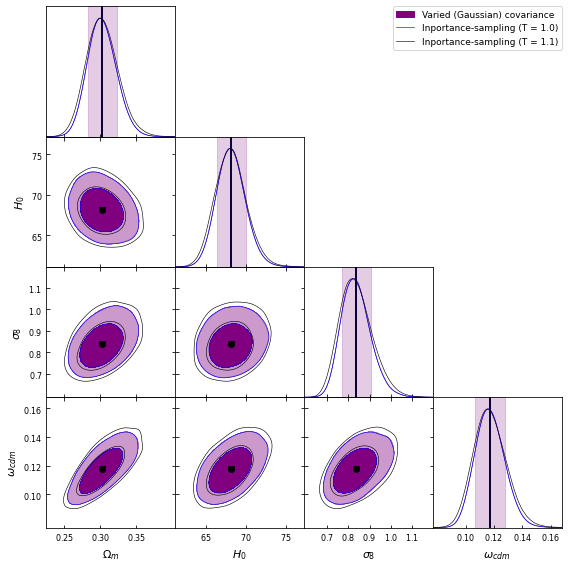

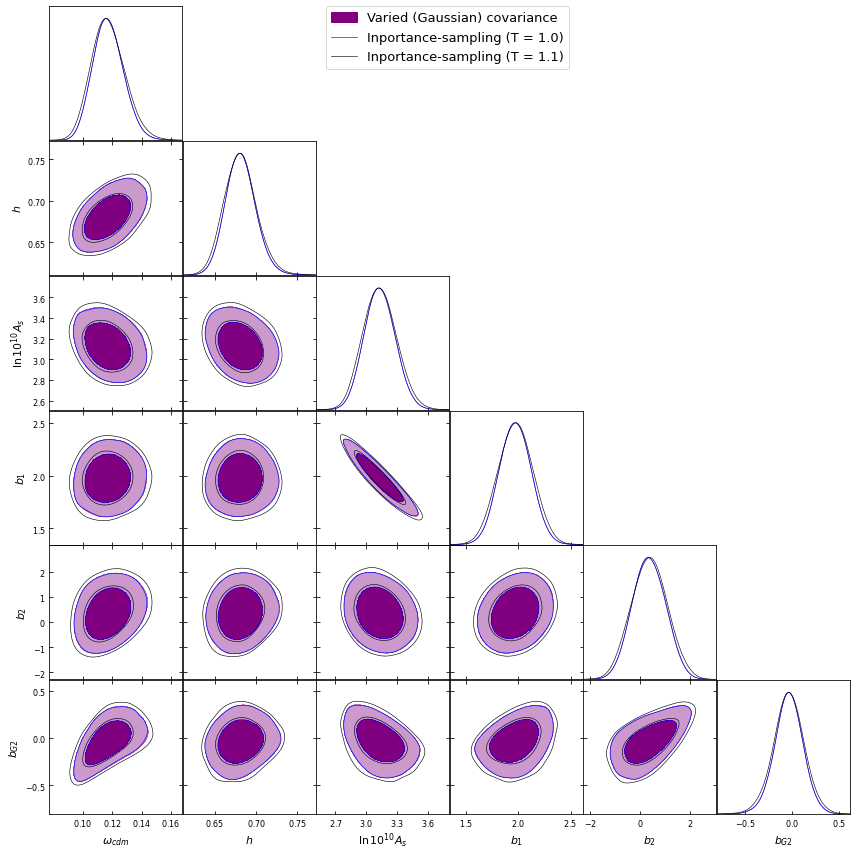

In [9]:
labels =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]
g = plot_derived_contours([chain_no_det, chain_NG_1, chain_NG_2], 
                      ["Varied (Gaussian) covariance", "Inportance-sampling (T = 1.0)", "Inportance-sampling (T = 1.1)"], 
                      ["purple", "blue", "black"], [True, False, False], False, True)

axs = plot_cosmo_contours([chain_no_det, chain_NG_1, chain_NG_2], labels,
                      ["Varied (Gaussian) covariance", "Inportance-sampling (T = 1.0)", "Inportance-sampling (T = 1.1)"],
                      ["purple", "blue", "black"], 6, truth=[], fill=[True, False, False])

Removed no burn in
Removed no burn in
Removed no burn in
saving...
Removed no burn in
Removed no burn in
Removed no burn in


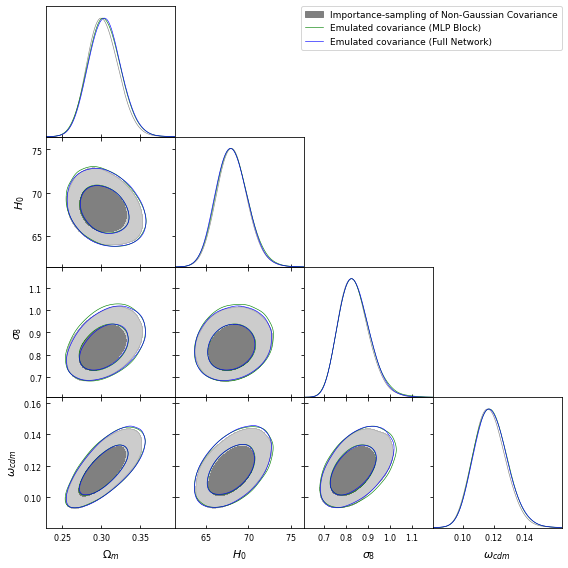

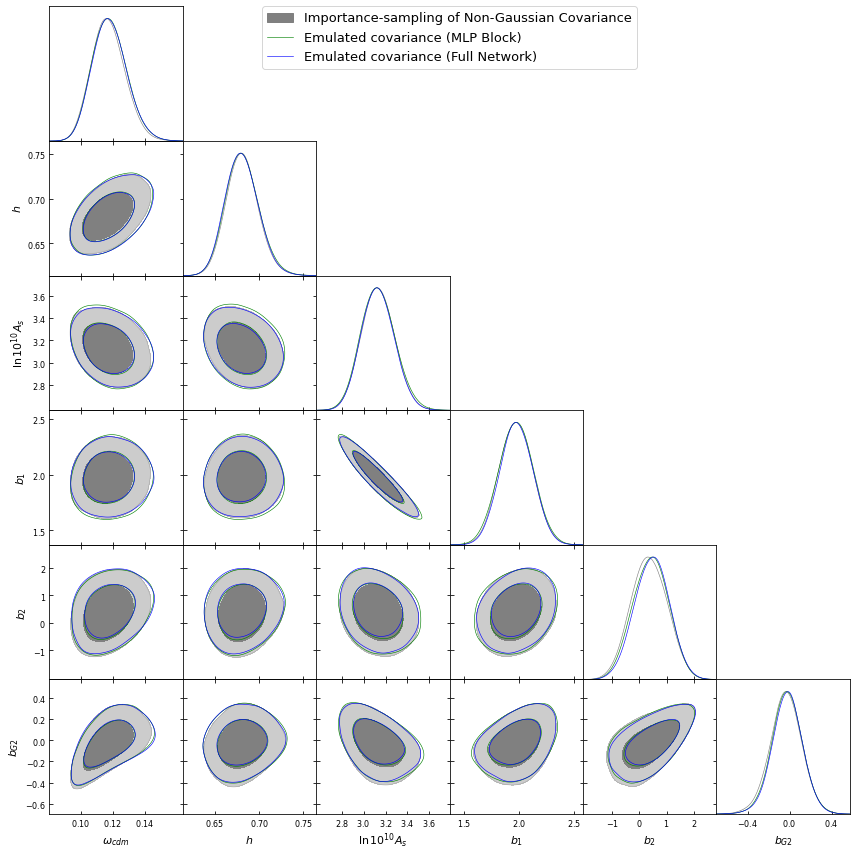

In [13]:
# g = plot_derived_contours([chain_NG, chain_MLP], 
#                       ["Inportance-sampling of Non-Gaussian Covariance", "Emulated covariance (MLP)"],
#                       ["grey", "green"], [True, False], False)

# axs = plot_cosmo_contours([chain_NG, chain_MLP], labels,
#                       ["Inportance-sampling of Non-Gaussian Covariance", "Emulated covariance (MLP)"],
#                       ["grey", "green",], 6, truth=[], fill=[True, False])
g = plot_derived_contours([chain_NG_1, chain_MLP, chain_MLP_T], 
                      ["Importance-sampling of Non-Gaussian Covariance", "Emulated covariance (MLP Block)", "Emulated covariance (Full Network)"],
                      ["grey", "green", "blue"], [True, False, False], False, False, "Non-Gaussian-Test.pdf")

axs = plot_cosmo_contours([chain_NG_1, chain_MLP, chain_MLP_T], labels,
                      ["Importance-sampling of Non-Gaussian Covariance", "Emulated covariance (MLP Block)", "Emulated covariance (Full Network)"],
                      ["grey", "green", "blue"], 6, truth=[], fill=[True, False, False])

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
saving...
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


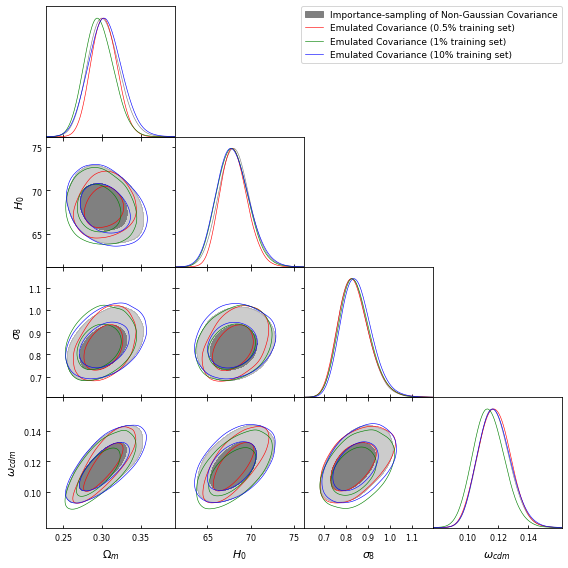

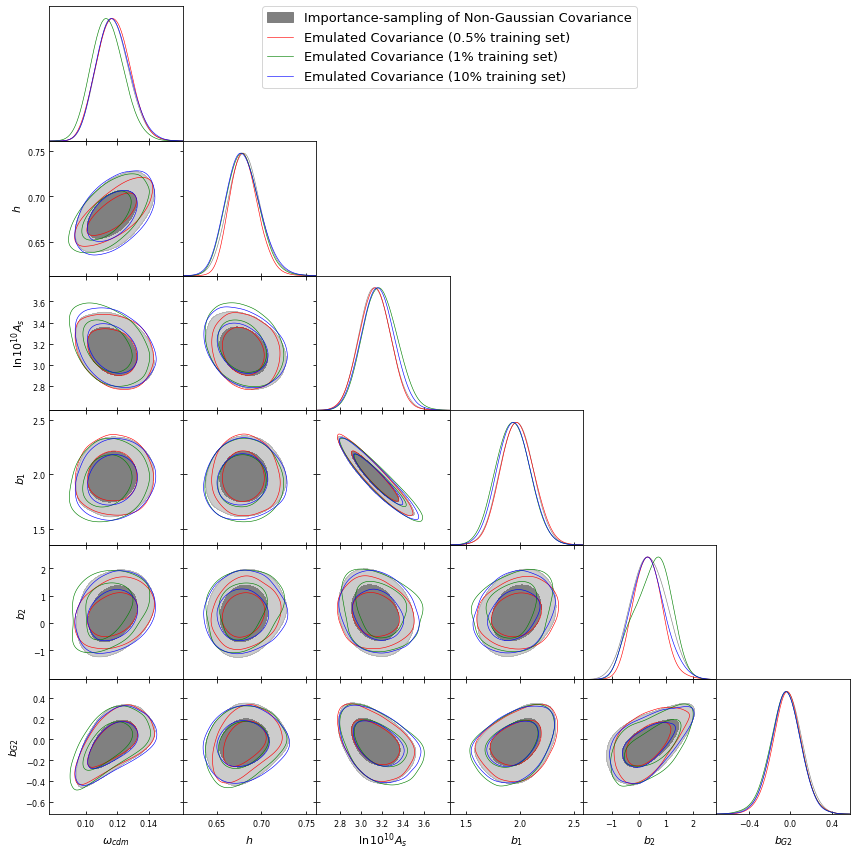

In [26]:
g = plot_derived_contours([chain_NG_1, chain_MLP_T_0005, chain_MLP_T_001, chain_MLP_T_01], 
                      ["Importance-sampling of Non-Gaussian Covariance", "Emulated Covariance (0.5% training set)", "Emulated Covariance (1% training set)", "Emulated Covariance (10% training set)"],
                      ["grey", "red", "green", "blue"], [True, False, False, False], False, False, "Datasize-contours.pdf")

axs = plot_cosmo_contours([chain_NG_1, chain_MLP_T_0005, chain_MLP_T_001, chain_MLP_T_01], labels,
                      ["Importance-sampling of Non-Gaussian Covariance", "Emulated Covariance (0.5% training set)", "Emulated Covariance (1% training set)", "Emulated Covariance (10% training set)"],
                      ["grey", "red", "green", "blue"], 6, truth=[], fill=[True, False, False, False])

In [25]:
# g = plot_derived_contours([chain_NG_1, chain_MLP_T, chain_MLP_T_small], 
#                       ["Inportance-sampling of Non-Gaussian Covariance", "MLP (full training set)", "MLP (10% training set)"],
#                       ["grey", "green", "red"], [True, False, False], False)

# axs = plot_cosmo_contours([chain_NG_1, chain_MLP_T, chain_MLP_T_small], labels,
#                       ["Inportance-sampling of Non-Gaussian Covariance", "MLP-T (full training set)", "MLP-T (10% training set)"],
#                       ["grey", "green", "red"], 6, truth=[], fill=[True, False, False])

## Deviance Information Criterion  
One of the new Euclid papers (https://arxiv.org/pdf/2211.12965.pdf) found that using a cosmology-dependent covariance matrix is "statistically preffered" even with the Carron 2013 result by calculating the following statistic,  
$$DIC = \langle \chi^2 \rangle + \left(\langle \chi^2 \rangle - \chi^2(\theta_{input})\right)$$  
(See https://rss.onlinelibrary.wiley.com/doi/full/10.1111/1467-9868.00353 for where this comes from). The second term in parenthesis describes the complexity of the model, so you would expect it to be **bigger** for models that are worse. A model that fits the data better will have a smaller $\langle \chi^2 \rangle$.  

The argument of the Euclid paper on why you can vary the covariance is - cosmology dependence is non-negligible -> we don't see a bias in the best-fit -> If you look at DIC the cosmology-dependent covariance method fits the data better -> If you do that with data generated from a Gaussian distribution you get the same DIC. I **think**
the takeawsy they're going for is that assuming a gaussian likelihood for their data is a really good approximation, so Carron 2013 doens't apply.

According to the Jeffry's scale (what is that?), a $\Delta DID < -10$ indicates model 2 is "decisively preferred" (see https://academic.oup.com/mnras/article/463/2/1416/2892353#57276260). I have chains to calculate this, so let's try doing that! 

In [8]:
Mat_Calc = CovaPT.Analytic_Covmat(0.61)
dx=np.loadtxt("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/ngc_z3/pk_ngc_z3_sim.dat", skiprows = 0)
k1 = dx[:,0][:25]
Pk01 = dx[:,1][:25]
Pk21 = dx[:,2][:25]
data_vector = np.concatenate([Pk01, Pk21])
C_fid_file = np.load("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_Fid.npz")
C_fid = C_fid_file["C_G"]
window_dir = "/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/Updated/"

theta_fid = np.array([67.77, 0.1184, 3.0446, 2., 0., 0., 0., 0., 500., 0.])

def dic(chain, use_det=False, best_fit=True):
    chi2_list = chain["loglike"]
    avg_chi2 = 2*np.mean(chi2_list)
    # avg_chi2
    if use_det == False:
        avg_chi2 += np.linalg.slogdet(C_fid)[1]
    
    # chi2(avg)
    # calculate chi2(theta) with theta being the input / fiducial cosmology
    if best_fit==False:
        theta = theta_fid
    # calculate chi2(theta) with theta being the mean (best-fit) cosmology
    else:
        theta = np.array([np.mean(chain["H0"]), np.mean(chain["omch2"]),
                          np.mean(chain["As"]), np.mean(chain["b1"]),
                          np.mean(chain["b2"]), np.mean(chain["bG2"]), 0.,0.,500., 0.])
        
    C_G, model_vector = Mat_Calc.get_gaussian_covariance(theta, return_Pk=True)    
    C_marg, model_vector, om0, s8 = Mat_Calc.get_marginalized_covariance(theta, C_G, window_dir)
    C_inv = np.linalg.inv(C_marg)
    x = data_vector - model_vector
    b1 = 2.; b2 = 0.; bG2 = 0.

    chi2_best = np.matmul(x.T, np.matmul(C_inv, x)) + (b2 - 0.)**2./1**2. + (bG2 - 0.)**2/1**2.
    chi2_best = chi2_best + np.linalg.slogdet(C_marg)[1]
    
    print(avg_chi2, chi2_best, 2*np.amin(chi2_list))
    deviance = avg_chi2 + avg_chi2 - chi2_best
    return deviance

In [9]:
did_fixed = dic(chain_fixed, False)
did_varied_1 = dic(chain_det, True)
did_varied_2 = dic(chain_no_det, False)

print("DIC = {:0.2f} (fixd),\t {:0.2f} (varied),\t {:0.2f} (varied without determinant)".format(did_fixed, did_varied_1, did_varied_2))
print("DIC difference (varied with determinant - fixed) = {:0.2f}".format(did_varied_1 - did_fixed))
print("DIC difference (varied without determinant - fixed) = {:0.2f}".format(did_varied_2 - did_fixed))

627.9495603544397 624.1645960447663 34.781
600.7116336239103 585.8856360130163 591.142
626.5627293436235 628.2676898524176 33.353
DIC = 631.73 (fixd),	 615.54 (varied),	 624.86 (varied without determinant)
DIC difference (varied with determinant - fixed) = -16.20
DIC difference (varied without determinant - fixed) = -6.88


In [10]:
chain_scaled = chain_fixed.copy()
chain_scaled["loglike"]+= (0.5*np.linalg.slogdet(C_fid)[1])
print(chain_scaled["loglike"][0], chain_fixed["loglike"][0])

# axes = plot_derived_contours([chain_fixed, chain_scaled],
#                              [r"Fixed covariance (no determinant term)", "Fixed cvariance (with determinant term)"],
#                              ["blue", "red"], [True, False], True, show_bestfit=True)
# plot_cosmo_contours([chain_fixed, chain_scaled], labels,
#                     [r"Fixed covariance (no determinant term)", "Fixed cvariance (with determinant term)"],
#                     ["blue", "red"], 6, truth=truth, fill=[True, False])

313.6072006481709 20.213


### Recreate figure 9 of the Euclid paper  

To do this, let's assume that the power spectrum is gaussian distributed, so we can draw random samples from a mutlivariate Gaussian with mean and covariance matrx taken at the input comsology

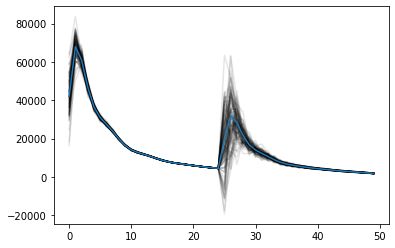

In [11]:
# C = C_fid_file["C_G"] + C_fid_file["C_NG"]
mean = data_vector

N_samples = 100
# samples = np.zeros((N_samples, mean.shape[0]))
# rng = np.random.default_rng()
# for i in range(N_samples):
#     samples[i] = rng.multivariate_normal(mean, C).T

# plt.plot(mean)
# for i in range(N_samples):
#     plt.plot(samples[i], c="black", alpha=0.3)
    
#np.savez("../Data/pk_ngc_z3_noisy.npz", k=k1, pk_noisy=samples)
dx = np.load("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/ngc_z3/pk_ngc_z3_noisy.npz")
k1 = dx["k"]
pk_noisy = dx["pk_noisy"]

for i in range(N_samples):
    plt.plot(pk_noisy[i], c="black", alpha=0.1)
plt.plot(mean)


In [20]:
fixed_dir = "noisy-data/model-vary/"
varied_dir = "noisy-data/cov-vary-d/"
varied_nd_dir = "noisy-data/cov-vary-single-nd/"
full_nd_dir = "noisy-data/full-vary-nd/"
full_d_dir = "noisy-data/full-vary-d/"

chain_fixed_noisy = load_chains(fixed_dir, [25, 28, 25, 20], names_marg)
chain_varied_noisy_det = load_chains(varied_dir, [933, 1000, 1015, 992], names_marg)
#chain_varied_noisy_no_det = load_chains(varied_nd_dir, [442, 481, 493, 527], names_marg)
chain_varied_noisy_no_det = load_chains(varied_nd_dir, [1894, 1704, 1816, 1631], names_marg)
chain_full_noisy_nd = load_chains(full_nd_dir, [81, 68, 84, 79], names_marg)
chain_full_noisy_d = load_chains(full_d_dir, [378, 408, 395, 335], names_marg)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


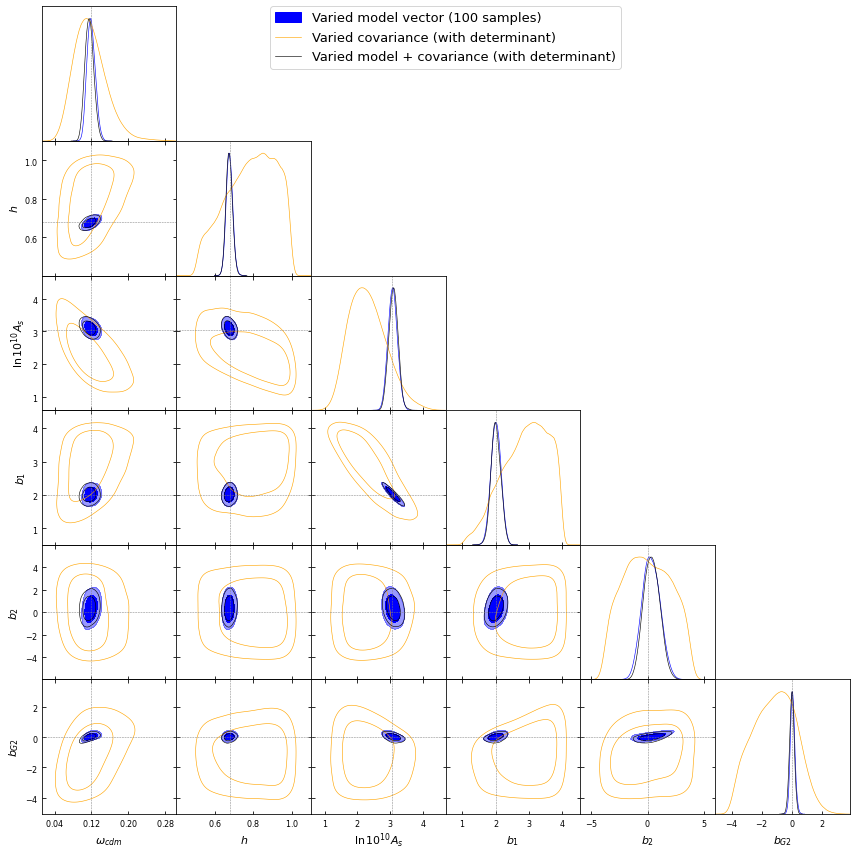

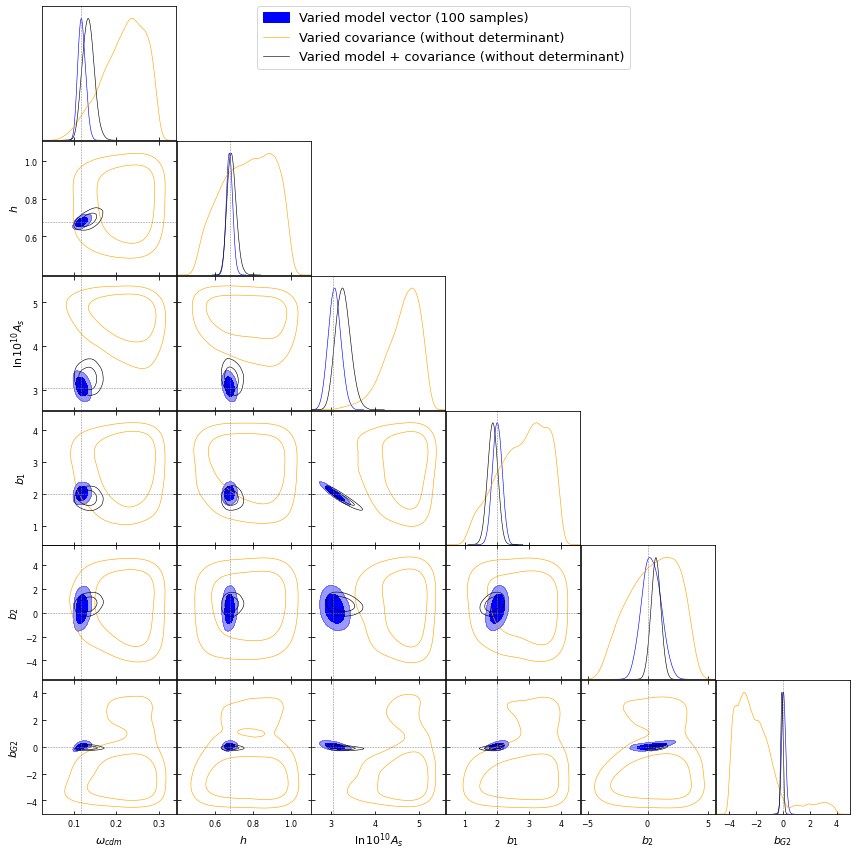

In [21]:
plot_cosmo_contours([chain_fixed_noisy, chain_varied_noisy_det, chain_full_noisy_d], labels,
                    [r"Varied model vector (100 samples)", "Varied covariance (with determinant)", "Varied model + covariance (with determinant)"],
                    ["blue", "orange", "black"], 6, truth=truth, fill=[True, False, False])

plot_cosmo_contours([chain_fixed_noisy, chain_varied_noisy_no_det, chain_full_noisy_nd], labels,
                    [r"Varied model vector (100 samples)", "Varied covariance (without determinant)", "Varied model + covariance (without determinant)"],
                    ["blue", "orange", "black"], 6, truth=truth, fill=[True, False, False])

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


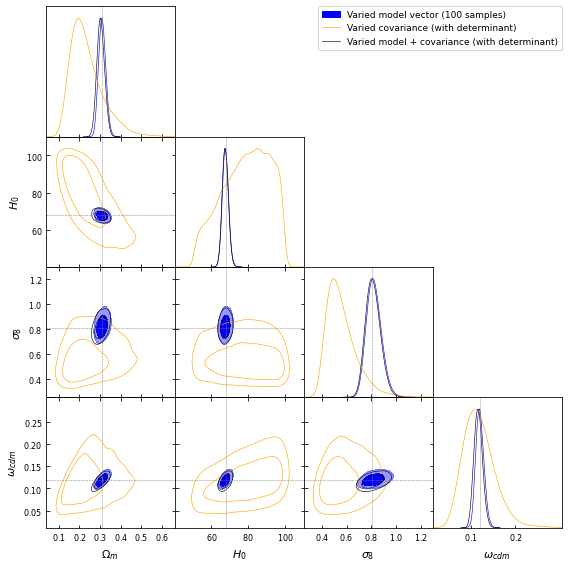

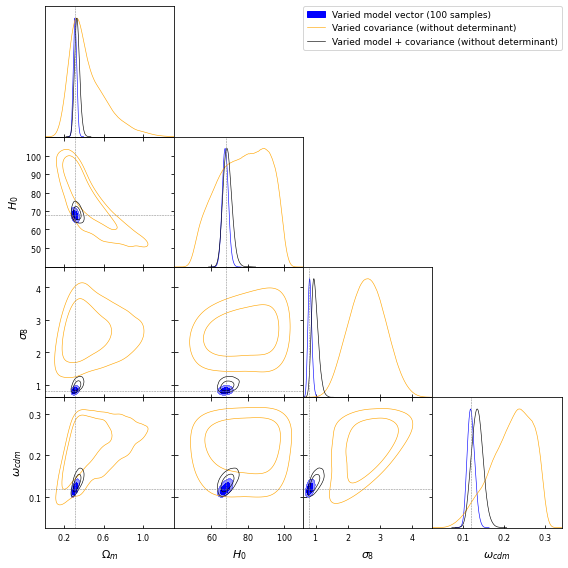

In [22]:
plot_derived_contours([chain_fixed_noisy, chain_varied_noisy_det, chain_full_noisy_d],
                      [r"Varied model vector (100 samples)", "Varied covariance (with determinant)", "Varied model + covariance (with determinant)"],
                      ["blue", "orange", "black"], [True, False, False], True, show_bestfit=False)

plot_derived_contours([chain_fixed_noisy, chain_varied_noisy_no_det, chain_full_noisy_nd],
                      [r"Varied model vector (100 samples)", "Varied covariance (without determinant)", "Varied model + covariance (without determinant)"],
                      ["blue", "orange", "black"], [True, False, False], True, show_bestfit=False)

In [15]:
did_fixed = dic(chain_fixed_noisy, True)
did_varied_1 = dic(chain_full_noisy_d, True)
did_varied_2 = dic(chain_full_noisy_nd, False)

print("DIC = {:0.2f} (fixd),\t {:0.2f} (varied),\t {:0.2f} (varied without determinant)".format(did_fixed, did_varied_1, did_varied_2))
print("DIC difference (varied with determinant - fixed) = {:0.2f}".format(did_varied_1 - did_fixed))
print("DIC difference (varied without determinant - fixed) = {:0.2f}".format(did_varied_2 - did_fixed))

673.0197286338941 624.0260158072118 666.584
672.0738410248496 624.7490680010878 665.958
660.8270791995013 656.4876429678402 67.3402
DIC = 722.01 (fixd),	 719.40 (varied),	 665.17 (varied without determinant)
DIC difference (varied with determinant - fixed) = -2.61
DIC difference (varied without determinant - fixed) = -56.85


In [24]:
def get_chi2_noisy(C_marg, params, pk_noisy, pk_fid):
    avg_chi2 = 0
    #det_C = np.linalg.slogdet(C)[1]
    det_C_marg = np.linalg.slogdet(C_marg)[1]
    C_inv_marg = np.linalg.inv(C_marg)
    
    for i in range(pk_noisy.shape[0]):
        x1 = pk_noisy[i] - pk_fid
        chi2 = np.inner(x1, np.inner(C_inv_marg, x1))
        chi2 += (params[4] - 0.)/1**2 + (params[5] - 0.)/1**2
        chi2 += det_C_marg
        avg_chi2 += chi2
    return avg_chi2 / pk_noisy.shape[0]

def get_chi2_nomarg(C, params, pk_noisy, pk_fid):
    avg_chi2 = 0
    det_C = np.linalg.slogdet(C)[1]
    C_inv = np.linalg.inv(C)
    
    for i in range(pk_noisy.shape[0]):
        x1 = pk_noisy[i] - pk_fid
        chi2 = np.inner(x1, np.inner(C_inv, x1))
        chi2 += (params[4] - 0.)/1**2 + (params[5] - 0.)/1**2
        chi2 += det_C
        avg_chi2 += chi2
    return avg_chi2 / pk_noisy.shape[0]

In [25]:
# test that the minimum chi2 of the cov-varied chain makes sense

Mat_Calc = CovaPT.Analytic_Covmat(0.61)
Cov_Emulator = CovNet.Emulator.CovNet("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP-T/")
window_dir = "/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/Updated/"

dx = np.load("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/ngc_z3/pk_ngc_z3_noisy.npz")
k1 = dx["k"]
pk_noisy = dx["pk_noisy"]

params_fid = theta_fid
params_best = np.array([np.mean(chain_varied_noisy_det["H0"]),
                        np.mean(chain_varied_noisy_det["omch2"]),
                        np.mean(chain_varied_noisy_det["As"]),
                        np.mean(chain_varied_noisy_det["b1"]),
                        np.mean(chain_varied_noisy_det["b2"]),
                        np.mean(chain_varied_noisy_det["bG2"]), 0, 0, 500, 0])

cov_fid = Cov_Emulator.get_covariance_matrix(params_fid[:6])
cov_best = Cov_Emulator.get_covariance_matrix(params_best[:6])

cov_marg_fid, model_fid, Om0, s8 = Mat_Calc.get_marginalized_covariance(params_fid, cov_fid, window_dir)
cov_marg_best, model_best, Om0, s8 = Mat_Calc.get_marginalized_covariance(params_best, cov_best, window_dir)

chi2_fid = get_chi2_noisy(cov_marg_fid, params_fid, pk_noisy, data_vector)
chi2_best = get_chi2_noisy(cov_marg_best, params_best, pk_noisy, data_vector)

chi2_fid_1 = get_chi2_nomarg(cov_fid, params_fid, pk_noisy, data_vector)
chi2_best_1 = get_chi2_nomarg(cov_best, params_best, pk_noisy, data_vector)

print("chi2 from fiducial cosmology = {:0.2f}".format(chi2_fid))
print("chi2 from best-fit cosmology = {:0.2f}".format(chi2_best))

print("chi2 from fiducial cosmology (no marginalization) = {:0.2f}".format(chi2_fid_1))
print("chi2 from best-fit cosmology (no marginalization) = {:0.2f}".format(chi2_best_1))
print("Lowest chi2 in chain = {:0.2f}".format(2*np.amin(chain_varied_noisy_det["loglike"])))

chi2 from fiducial cosmology = 658.66
chi2 from best-fit cosmology = 653.76
chi2 from fiducial cosmology (no marginalization) = 636.92
chi2 from best-fit cosmology (no marginalization) = 637.47
Lowest chi2 in chain = 652.38


In [28]:
all_theory, theory0, theory2, theory4, fz, Omega_m, sigma8 = Mat_Calc.Pk_CLASS_PT(params_fid, False)
print(all_theory.shape)
np.savez("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/ngc_z3/pk_ngc_z3_noisy.npz",
         pk_noisy=pk_noisy, k=k1, fid_theory=all_theory)

(96, 400)


# Old Code

In [ ]:
Mat_Calc = CovaPT.Analytic_Covmat(0.61)
C_G, C_SSC, C_T0 = Mat_Calc.get_full_covariance(params_test)
C_fid = C_G + C_SSC + C_T0
#C_fid = C_G

t2 = time.time()
print("Matrix generated in {:0.2f} s".format(t2 - t1))

print(C_fid.shape)

print("cond(C) = {:0.3e}".format(np.linalg.cond(C_fid)))
try:
    L = np.linalg.cholesky(C_fid)
    print("Covariance matrix is positive-definite :)")
except np.linalg.LinAlgError as err:
    print("Covariance matrix is NOT positive-definite!")
    
try:
    L = np.linalg.cholesky(C_G)
    print("Gaussian term is positive-definite :)")
except np.linalg.LinAlgError as err:
    print("Gaussian term is NOT positive-definite!")

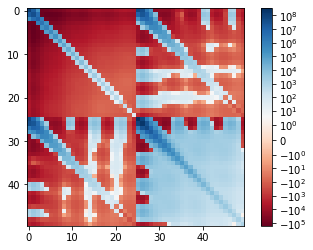

In [40]:
plt.figure()
plt.imshow(C_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
plt.colorbar()

4191.924735522535 2748.4879135930723


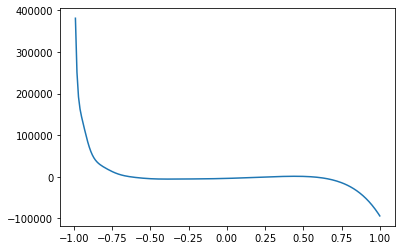

In [55]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad
import scipy
b1 = params_test[3]
Omega_m = (params_test[1] + 0.02237 + 0.00064) / (params_test[0]/100)**2

def Dz(z,Om0):
    return(scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3)
                                /scipy.special.hyp2f1(1/3., 1, 11/6., 1-1/Om0)/(1+z))

pdata = Mat_Calc.Pk_lin_CLASS(params_test[0], params_test[1], 0.02237, params_test[2]*3.0447, 0.9649)

Plin=InterpolatedUnivariateSpline(pdata[:,0], Dz(0.61, Omega_m)**2*b1**2*pdata[:,1])

k1 = 0.195; k2 = 0.195
#k1 = 0.20500000000000002; k2= 0.20500000000000002
k1 = 0.185; k2 = 0.185
u = np.linspace(-1, 1, 200)
integrand = Mat_Calc.trispIntegrand(u, k1,k2,Plin)
temp = quad(Mat_Calc.trispIntegrand, -1, 1,args=(k1,k2,Plin), limit=200)[0]/2.

du = u[2] - u[1]
temp2 = np.sum(integrand[1:] * du) / 2.
print(temp, temp2)

plt.plot(u, integrand)

In [228]:
from astropy.modeling import models, fitting

det_file = np.load("/home/joeadamo/Research/CovNet/Data/determinants.npz")

det_params = det_file["params"]
#det_term = det_file["det_marg"]
det_term = det_file["det_gaussian"]

det_params = det_params[~np.isnan(det_term)]
det_term = det_term[~np.isnan(det_term)]

temp = det_params[:,1].copy()
det_params[:,1] = det_params[:,0].copy()
det_params[:,0] = temp
#det_params[:,2] = det_params[:,2] * 3.0347

def make_contours(x, y, z, bins, bins_new, values):
    
    # first average out the determinant over some bin resolution to make a regular grid of data points
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    y_grid, x_grid = np.mgrid[:bins, :bins]
    y_fit, x_fit = np.mgrid[:bins_new, :bins_new] *bins / bins_new
    
    p_init = models.Polynomial2D(degree=4)
    fit_p = fitting.LevMarLSQFitter()
    poly_fit = fit_p(p_init, x_grid, y_grid, z_new)
    z_fit = poly_fit(x_fit, y_fit)
    
    x_new = np.linspace(np.amin(x), np.amax(x), bins_new)
    y_new = np.linspace(np.amin(y), np.amax(y), bins_new)
    
    curves_x, curves_y = [],[]
    for i in range(len(values)):
        z = z_fit - values[i]
        curve_x = []; curve_y = []
        curve_sort = []
        for i in range(bins_new):
            for j in range(bins_new):
                if abs(z[-j,i]) < 1e-1:
                    curve_x.append(x_new[i])
                    curve_y.append(y_new[j])
                    curve_sort.append(np.sqrt(1.*i**2 + 1.*j**2))
        sort_idx = np.array(curve_sort).argsort()
        curve_x = np.array(curve_x)[sort_idx]
        curve_y = np.array(curve_y)[sort_idx]

        curves_x.append(curve_x)
        curves_y.append(curve_y)
    return x_new, y_new, curves_x, curves_y, z_fit

def make_diagonal(x, y, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

450.8309626455644 1204.4540400415688
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:xlabel='$h$'>]


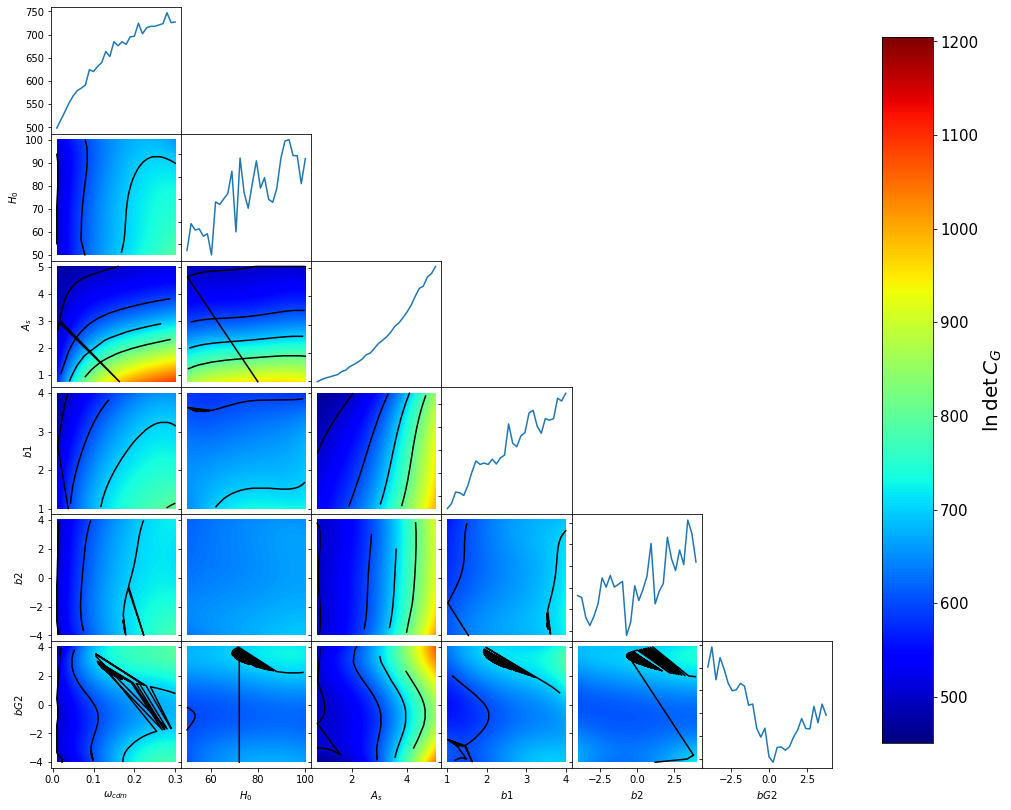

In [231]:
label=r"$\ln{\det{C_G}}$"
names = ['omch2', 'h', "As", "b1", "b2", "bG2", "chi_squared"]
labels= [r'$\omega_{cdm}$', r"$H_0$", r"$A_s$", "$b1$", "$b2$", "$bG2$", label]
cmap="jet"
print(np.amin(det_term), np.amax(det_term))
extents=[np.amin(det_term), np.amax(det_term)]

print(g.subplots[1:,1])
# for i in range(6):
#     for j in range(6):
#         ax = g.subplots[i, j]
        
# for ax in g.subplots[2:,1]:
#     try:
#         ax.axvline(0.7, color='gray', ls='--')
#         print("hi!")
#     except: continue
    
fig, axs = plt.subplots(6,6, figsize=(14,14))
for i in range(6):
    for j in range(6):
        if i < j:
            axs[i][j].axis("off")
            continue
        if i == j:
            x, y = make_diagonal(det_params[:,j], det_term, 30)
            #axs[i][j].axhline(0, color="red")
            axs[i][j].plot(x, y)
            #axs[i][j].set_yscale("log")
        else:
            X, Y, c_x, c_y, Z = make_contours(det_params[:,j], det_params[:,i], det_term, 30, 250, [500, 600, 700, 800])
            axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
            for a in range(4):
                axs[i,j].plot(c_x[a], c_y[a], c="black")
            axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
            axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
            # if log_scale == True: img = axs[i][j].scatter(params[:,j], params[:,i], c=data, s=1, alpha=0.8, cmap=cmap,
            #                                               norm=colors.SymLogNorm(vmin=extents[0], vmax=extents[1], linthresh=1))
            # else: img = axs[i][j].scatter(params[:,j], params[:,i], c=data, s=1, vmin=extents[0], vmax=extents[1], alpha=0.8, cmap=cmap)
        #if i != j: axs[i][j].axhline(params_fid[i], linestyle="--", c="black")
        #axs[i][j].axvline(params_fid[j], linestyle="--", c="black")
        if i == 5: axs[i][j].set_xlabel(labels[j])
        if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
        if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
        elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
        elif j != 0 and i != 5:
            axs[i][j].xaxis.set_ticklabels([])
            axs[i][j].yaxis.set_ticklabels([])

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label(labels[-1] ,size=20)
cbar.ax.tick_params(labelsize=15) 
plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout(

#IPython.display.display(g.fig)

(10, 10)
3.98e-05
2.12e-04
1.54e-02
2.32e-02
3.52e-01
3.09e-02
2.08e+00
1.67e+00
9.15e-01
2.58e-03


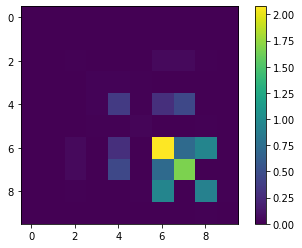

In [50]:
#chain_sub = np.vstack([chain_no_det["H0"], chain_no_det["omch2"], chain_no_det["Omega_m"], chain_no_det["sigma8"]]).T
chain_sub = np.vstack([chain_5["omch2"], chain_5["h"], chain_5["As"], chain_5["b1"], \
                       chain_5["b2"], chain_5["bG2"], chain_5["cs0"], chain_5["cs2"], \
                       chain_5["Pshot"], chain_5["b4"]]).T
C_theta = np.cov(chain_sub, rowvar=False)

print(C_theta.shape)
for i in range(C_theta.shape[0]):
    print("{:0.2e}".format((C_theta[i,i])))

header = "omega_cdm, h, ln10^{10}A_s, b^{(1)}_1, b^{(1)}_2, b^{(1)}_{G_2},c^{(1)}_{0}, c^{(1)}_{2}, P^{(1)}_{shot}, b^{(1)}_4"#\Omega_m, sigma8"
    
np.savetxt(montepython_dir+"simulated-data/ms.covmat", C_theta, header=header)
L = np.linalg.cholesky(C_theta)

plt.imshow(C_theta, vmin=0)
plt.colorbar()

#### code to recalculate the covariance matrix

In [41]:
# This cell computes the covariance matrix at some input cosmology
# t1 = time.time()
# params_fid = np.array([67.77,0.1184,1, 1.9485,-0.5387, 0.1, 5, -15, 100., 5e3])
# params_best = np.array([70.848,0.1120,0.7573, 2.8213,-0.2566, -0.0442, 12.0884, 4.54, 381.8, 984])
# params_marg =  np.array([67.77,0.1184,1, 1.9485,-0.5387, 0.1, 0, 0, 500., 0])
# params_marg_best =  np.array([70.725, 0.11182, 0.7243, 3.3323, -0.39812, -0.010124, 0, 0, 500., 0])
# params_far = np.array([85, 0.21182, 1.2243, 0.3323, -0.39812, -0.010124, 0, 0, 500., 0])
# C_G = CovaPT.get_gaussian_covariance(params_marg_best)
# C_SSC, C_T0 = CovaPT.get_non_gaussian_covariance(params_marg_best)
# C_fid = C_G + C_SSC + C_T0
# #C_fid = C_G
# t2 = time.time()
# print("Matrix generated in {:0.2f} s".format(t2 - t1))

# print(C_fid.shape)

# try:
#     L = np.linalg.cholesky(C_fid)
#     print("Covariance matrix is positive-definite :)")
# except np.linalg.LinAlgError as err:
#     print("Covariance matrix is NOT positive-definite!")
    
# np.savez("../Data/Cov_Marg_Best.npz", C_G=C_G, C_SSC=C_SSC, C_T0=C_T0)

AttributeError: module 'CovNet.CovaPT' has no attribute 'get_gaussian_covariance'

In [42]:
# plt.figure()
# plt.imshow(C_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
# plt.colorbar()

NameError: name 'C_fid' is not defined

<Figure size 432x288 with 0 Axes>

## Ultranest Code

In [7]:
fiducial_dir = "/home/joeadamo/Research/CovNet/chains/Ultranest/Simulated-Likelihood/full-model/"
#fiducial_dir = "/home/joeadamo/Research/CovNet/chains/Ultranest/HighZ-NGC/fixed-fiducial/"
best_dir = "/home/joeadamo/Research/CovNet/chains/Ultranest/HighZ-NGC/fixed-best/"

#prefix = ["Fixed-", "No-T0-"]

# load in the chain as a structured array
chain_fid = np.genfromtxt(fiducial_dir+"chains/weighted_post.txt", names=True)
chain_best = np.genfromtxt(best_dir+"chains/weighted_post.txt", names=True)

stats_fid = np.genfromtxt(fiducial_dir+"info/post_summary.csv", names=True, delimiter=",")
stats_best = np.genfromtxt(best_dir+"info/post_summary.csv", names=True, delimiter=",")

# print(stats.dtype.names)
# print(chain.shape)
# print(chain[chain.dtype.names[2]])

In [70]:
# if there isn't a sigma8 column, calculate sigma8
# NOTE: this takes around 20 minutes!
# if not "sigma8" in chain.dtype.names:
#     new_names = np.append(chain.dtype.names, "sigma8")
#     print(new_names)
#     sigma8 = calc_sigma8(chain)


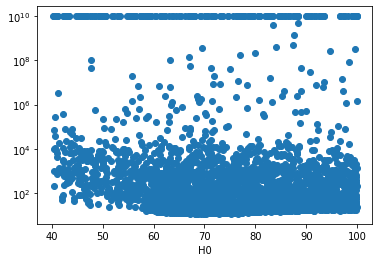

In [71]:
plt.scatter(chain_best["H0"], -chain_best["logl"])
plt.xlabel("H0")
plt.yscale("log")

Removed no burn in


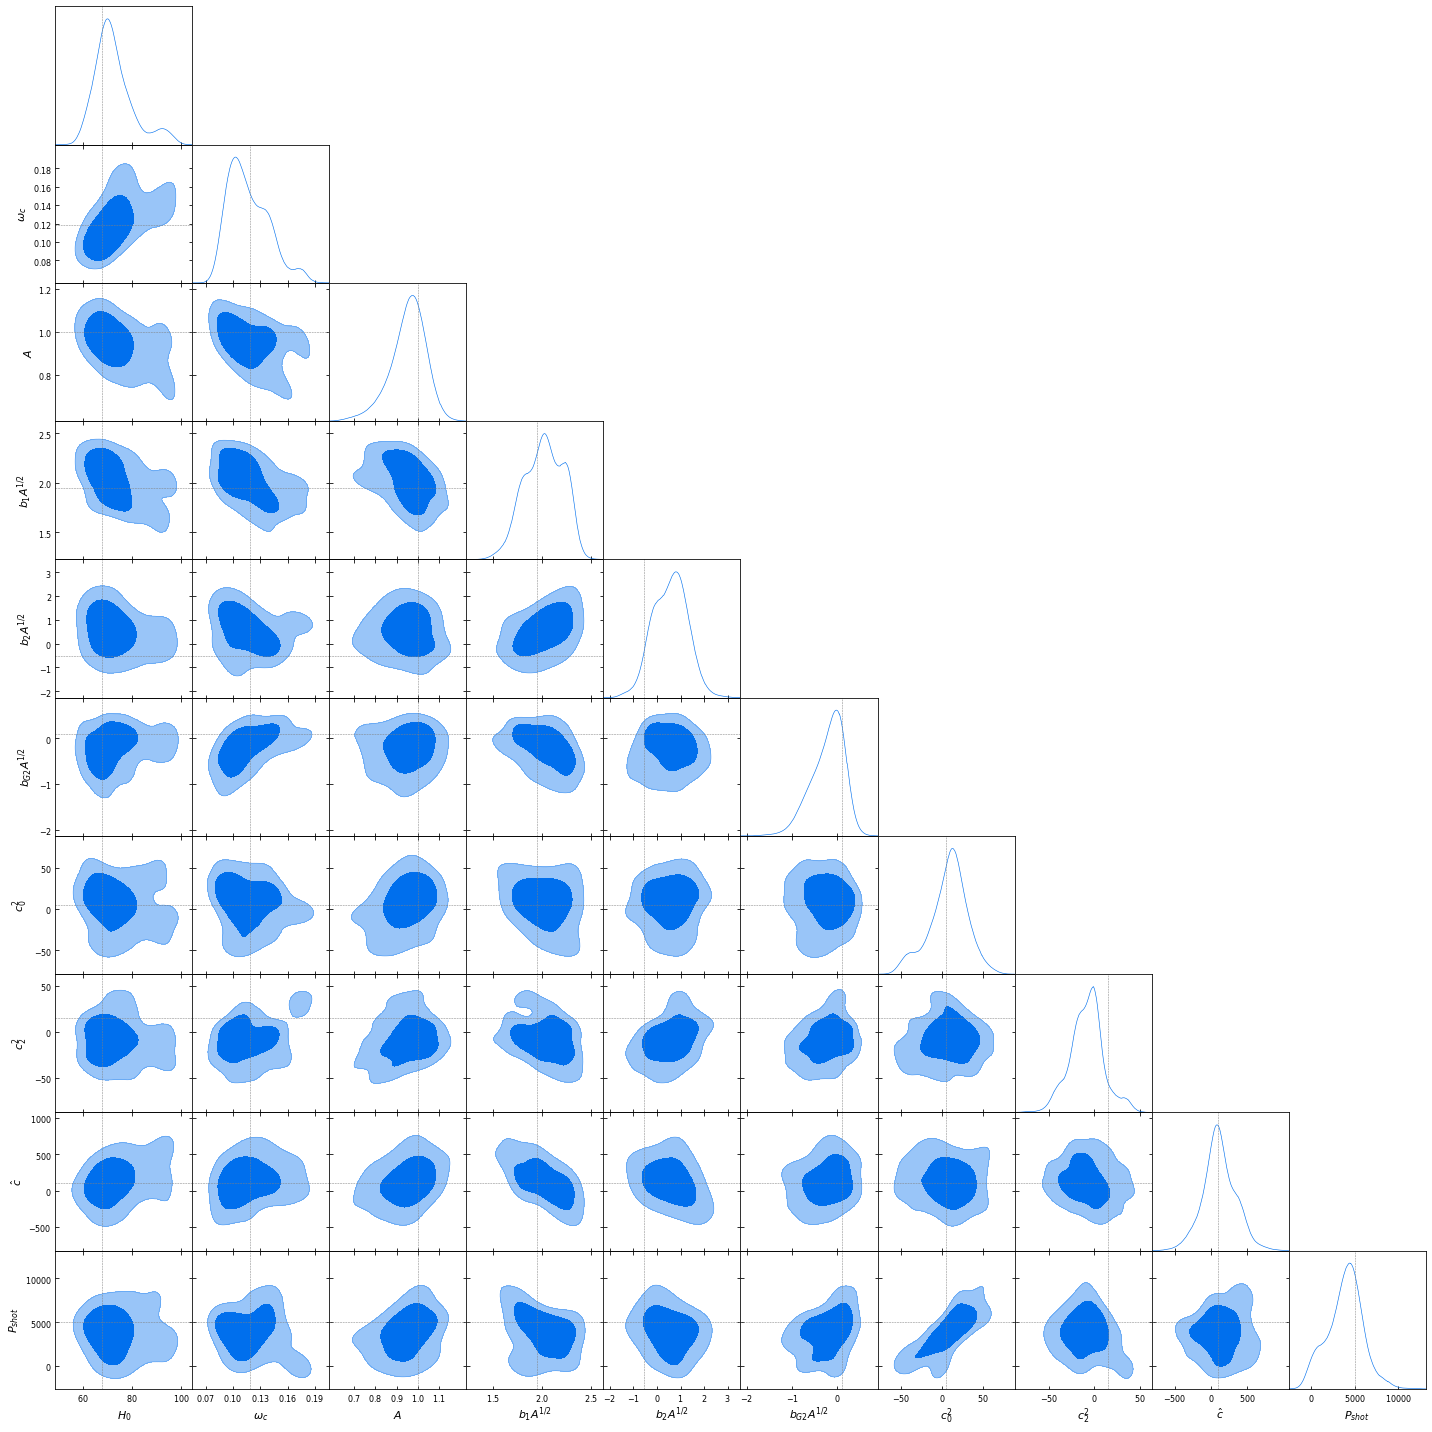

In [18]:
labels =  ["H_0", "\omega_c", "A", "b_1A^{1/2}", 'b_2A^{1/2}', "b_{G2}A^{1/2}", "c_0^2", "c_2^2", "\hat{c}", "P_{shot}"]
#labels =  ["H_0", "\omega_c"]#, "P_{shot}"]
cosmo_truth = [67.77, 0.11827,1,1.9485, -0.5387, 0.1, 5., 15., 100, 5e3]
#cosmo_truth = [67.77, 0.11827]#, 5e3]

#plot_cosmo_contours([chain_fid, chain_best], labels, cosmo_truth, ["Fixed Covariance (fiducial cosmology)", "Fixed Covariance (best-fit cosmology)"],10, True)
plot_cosmo_contours([chain_fid], labels, cosmo_truth, ["Fixed Covariance (fiducial cosmology)"],10, True)

Removed no burn in


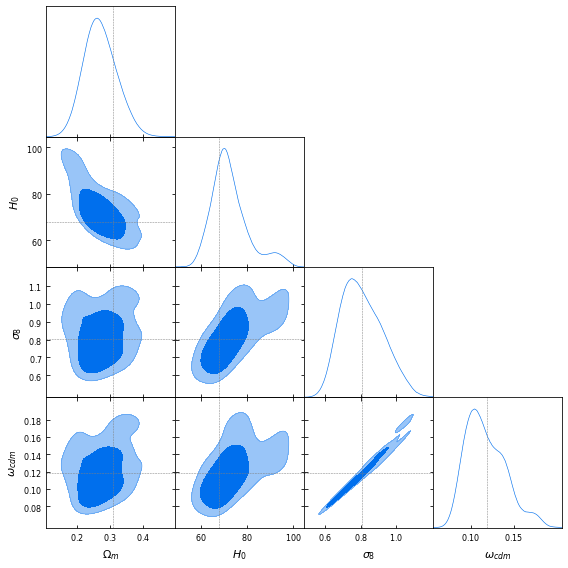

In [13]:
plot_derived_contours([chain_fid], ["Fixed Covariance (fiducial cosmology)"], True)
#plot_derived_contours([chain_fid, chain_best], ["Fixed Covariance (fiducial cosmology)", "Fixed Covariance (best-fit cosmology)"], True)

In [22]:
# Compare mean values with that of Wadekar et al (2020)
for name in chain_fid.dtype.names:
    # interval = st.norm.interval(alpha=0.68, loc=np.mean(chain[name]), scale=st.sem(chain[name]))
    # print(interval)
    if name != "weight" and name != "logl":
        mean = stats_fid[name+"_mean"]
        mean_2 = stats_best[name+"_mean"]
        #mean_2 = np.average((chain_fid[name]), weights=chain_fid["weight"])
        print(name)
        print("fiducial: {:0.4f} + {:0.4f} - {:0.4f} ({:0.4f})".format(stats_fid[name+"_mean"], mean - stats_fid[name+"_errlo"], stats_fid[name+"_errup"] - mean, stats_fid[name+"_stdev"]))
        print("updated:  {:0.4f} + {:0.4f} - {:0.4f} ({:0.4f})".format(stats_best[name+"_mean"], mean_2 - stats_best[name+"_errlo"], stats_best[name+"_errup"] - mean_2, stats_best[name+"_stdev"]))

H0
fiducial: 70.8476 + 5.9106 - 5.0003 (6.3261)
updated:  71.4000 + 5.1836 - 4.5914 (6.0215)
omch2
fiducial: 0.1120 + 0.0147 - 0.0142 (0.0155)
updated:  0.1153 + 0.0153 - 0.0163 (0.0162)
A
fiducial: 0.7573 + 0.0889 - 0.0873 (0.0948)
updated:  0.7160 + 0.0937 - 0.0943 (0.0938)
b1
fiducial: 2.8213 + 0.2298 - 0.2228 (0.2322)
updated:  2.9223 + 0.2160 - 0.2099 (0.2264)
b2
fiducial: -0.2566 + 0.9326 - 0.9594 (0.9610)
updated:  0.0434 + 0.8901 - 0.8928 (0.8494)
bG2
fiducial: -0.0442 + 0.7071 - 0.7011 (0.6666)
updated:  0.3067 + 0.6362 - 0.5960 (0.6098)
cs0
fiducial: 12.0884 + 24.6853 - 23.9548 (26.0740)
updated:  3.4233 + 29.6589 - 25.3655 (25.0910)
cs2
fiducial: 4.5396 + 23.5990 - 23.1982 (23.7613)
updated:  -1.2514 + 26.1512 - 26.9542 (26.2080)
cbar
fiducial: 381.8369 + 203.0332 - 204.8777 (207.1863)
updated:  327.0865 + 152.2400 - 146.8683 (161.6462)
Pshot
fiducial: 984.4084 + 1098.3636 - 1085.4467 (1109.4370)
updated:  862.8109 + 996.2532 - 1171.5305 (1189.8299)
Omega_0
fiducial: 0.2722 

In [33]:
# check how much the mean / error bars have shifted after switching input cosmologies
for name in chain_fid.dtype.names:
    
    if name != "weight" and name != "logl":
        shift = abs(stats_fid[name+"_mean"] - stats_best[name+"_mean"])
        shift_relative = shift / stats_fid[name+"_stdev"]
        sigma_shift = 100.*(stats_fid[name+"_stdev"] - stats_best[name+"_stdev"]) / stats_fid[name+"_stdev"]
        print(name)
        print("best-fit shift = {:0.3f}\t ({:0.2f} sigma)".format(shift, shift_relative))
        print("standard deviation shift = {:0.2f}%".format(sigma_shift))

## Old Metropolic-Hastings Code

In [ ]:
# load in the mcmc chain from file
N    = 100000
NDIM = 11
N_sub = 70000
file1 = np.load(data_dir+"mcmc_chains_Fixed.npz")
file2 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_Gaussian_Varied.npz")
file3 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_Cholesky_Varied.npz")
file4 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_SSC_Varied.npz")
file5 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_G_emulate_Varied.npz")
file6 = np.load(data_dir+"MCMC-Model Chains/mcmc_chains_Fixed_Far.npz")

chain_fixed = file1["chain"]
chain_fixed_far = file5["chain"]
chain_varied_G = file2["chain"]
chain_varied_G_emulated = file5["chain"]
chain_varied_C = file3["chain"]
chain_varied_SSC = file4["chain"]

#chain_fixed[:,3] = np.exp(chain_fixed[:,3]) / 1e10
chain_fixed_far[:,3] = np.exp(chain_fixed_far[:,3]) / 1e10
chain_varied_G[:,3] = np.exp(chain_varied_G[:,3]) / 1e10
chain_varied_G_emulated[:,3] = np.exp(chain_varied_G_emulated[:,3]) / 1e10
chain_varied_C[:,3] = np.exp(chain_varied_C[:,3]) / 1e10
chain_varied_SSC[:,3] = np.exp(chain_varied_SSC[:,3]) / 1e10

rate_T0 = file1["rate"]
rate_varied_G = file2["rate"]
rate_varied_C = file3["rate"]
rate_varied_SSC = file4["rate"]
lkl_T0 = file1["lkl"]
lkl_varied_G = file2["lkl"]
lkl_varied_C = file3["lkl"]
lkl_varied_SSC = file4["lkl"]

In [ ]:
fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM+1))
for i in range(NDIM):
    ax[i].plot(chain_fixed[:N_sub,i].T, 'k-', lw=0.3)
plt.show()  

In [26]:
# fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
# for i in range(NDIM):
#     ax[i].plot(chain_varied_G[:N_sub,i].T, 'k-', lw=0.3)
# plt.show()  

In [27]:
# fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
# for i in range(NDIM):
#     ax[i].plot(chain_varied_C[:N_sub,i].T, 'k-', lw=0.3)
# plt.show()  

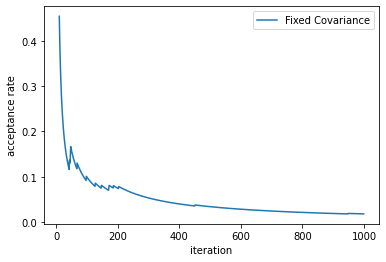

In [28]:
plt.plot(range(N)[10:N_sub], rate_T0[10:N_sub], label="Fixed Covariance")
#plt.plot(range(N)[10:N_sub], rate_varied_G[10:N_sub], label="Cosmo Dependent (Gaussian)")
#plt.plot(range(N)[10:N_sub], rate_varied_SSC[10:N_sub], label="Cosmo Dependent (Gaussian + SSC)")
#plt.plot(range(N)[10:N_sub], rate_varied_C[10:N_sub], label="Cosmo Dependent (Cholesky)")
plt.xlabel("iteration")
plt.ylabel("acceptance rate")
plt.legend()

950
[ 8.01339270e+01  6.02097967e-02  5.78783497e-02  1.12499559e+00
  9.97748712e-01  2.78217116e+00 -4.97658935e+00  7.10325142e+00
 -1.01587059e+01 -1.66330943e+02  5.63915219e+03]


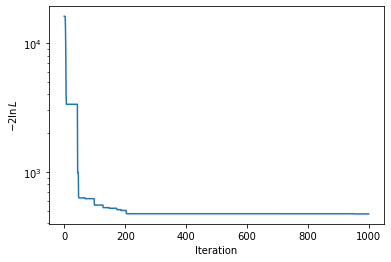

In [30]:
print(np.argmin(-2*lkl_T0[:N_sub]))
print(chain_fixed[:N_sub][-1])
plt.plot(range(N)[:N_sub], -2*lkl_T0[:N_sub])
plt.xlabel("Iteration")
plt.ylabel(r"$-2 \ln{L}$")
plt.yscale("log")

In [31]:
C_theta = np.cov(chain_fixed[0:N_sub], rowvar=False)
for i in range(C_theta.shape[0]):
    print("[",end =" ")
    for j in range(C_theta.shape[1]):
        print(str(C_theta[i,j]) + ",",end =" ")
    print("],")
    
for i in range(11):
    print(np.sqrt(C_theta[i,i]))

[ 0.1697034955221653, 0.0018756485455925004, -0.00012755042936932873, -0.010332333097359852, -0.0033011799151297146, 0.006200354536014686, -0.6436928031008571, -0.08722384596619201, -0.4350313866824416, -5.051284489525018, 256.2780292321567, ],
[ 0.0018756485455925004, 2.799370316852879e-05, -1.8453784982465928e-06, -0.00012758186346366332, -1.8352429736795777e-05, 0.0006312252042537553, -0.00801201765737572, -0.0004823754046332929, 0.0020136988499557746, -0.07129976129068936, 2.9971432614722766, ],
[ -0.00012755042936932873, -1.8453784982465928e-06, 1.280591606786456e-07, 1.3229372538141804e-05, 1.5038287395589148e-06, -3.961782848568164e-05, 0.0005532574588257828, 6.938278190532095e-05, 3.396951038779364e-05, 0.0041763784899615745, -0.17264736168221614, ],
[ -0.010332333097359852, -0.00012758186346366332, 1.3229372538141804e-05, 0.005992943270853318, 0.0002207541695949502, -0.00964197579582706, 0.03595480215171107, 0.036787840412673654, 0.052665129782016276, -0.4277753279325201, 30.2

In [18]:
N_BURN_IN = 4200

samples_fixed = chain_fixed[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_fixed_far = chain_fixed_far[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_G = chain_varied_G[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_G_emulated = chain_varied_G_emulated[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_SSC = chain_varied_SSC[N_BURN_IN:N_sub, :].reshape((-1,NDIM))
samples_varied_C = chain_varied_C[N_BURN_IN:N_sub, :].reshape((-1,NDIM))

## Figure of Merit Code  
The Figure of Merit is defined in https://www.nsf.gov/mps/ast/aaac/dark_energy_task_force/report/detf_final_report.pdf as  
$$ FoM = \sqrt{det(C_{\theta_i, \theta_j}^{-1})} $$  
Where C is the covariance matrix of 2 parameters $\theta_i$ and $\theta_j$ in a given MCMC chain (late time). Normally this stat is used for $w_0$ and $w_a$, but it can technically be used for any pair of parameters you are scanning over.

In [36]:
N_sub = 4000
def FoM(param_1, param_2, num_bins):
    chain_1 = np.vstack((chain_fixed[param_1][N_sub:], chain_fixed[param_2][N_sub:])).T
    chain_2 = np.vstack((chain_no_det[param_1][N_sub:], chain_no_det[param_2][N_sub:])).T

    FoM_1, FoM_2 = np.zeros(num_bins), np.zeros(num_bins)
    chain_len_1, chain_len_2 = chain_1.shape[0], chain_gaussian.shape[0]
    for b in range(num_bins):
        subchain_1 = chain_1[b*int(chain_len_1 / num_bins):(b+1)*int(chain_len_1 / num_bins), :]
        subchain_2 = chain_2[b*int(chain_len_2 / num_bins):(b+1)*int(chain_len_2 / num_bins), :]

        # calculate the covariance matrix of this subchain
        cov_1 = np.cov(subchain_1, rowvar=False)
        cov_2 = np.cov(subchain_2, rowvar=False)
        FoM_1[b] = np.sqrt(np.linalg.det(np.linalg.inv(cov_1)))
        FoM_2[b] = np.sqrt(np.linalg.det(np.linalg.inv(cov_2)))

    # Calculate the FoM for the last 30% of the chain
    cov_1 = np.cov(chain_1[int(0.7*chain_len_1):,:], rowvar=False)
    cov_2 = np.cov(chain_2[int(0.7*chain_len_2):,:], rowvar=False)
    FoM_30 = [np.sqrt(np.linalg.det(np.linalg.inv(cov_1))), np.sqrt(np.linalg.det(np.linalg.inv(cov_2)))]
    
    return FoM_1, FoM_2, FoM_30

/tmp/ipykernel_210620/3561141076.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Fixed Covariance", "Cosmo Dependent Covariance"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.03))


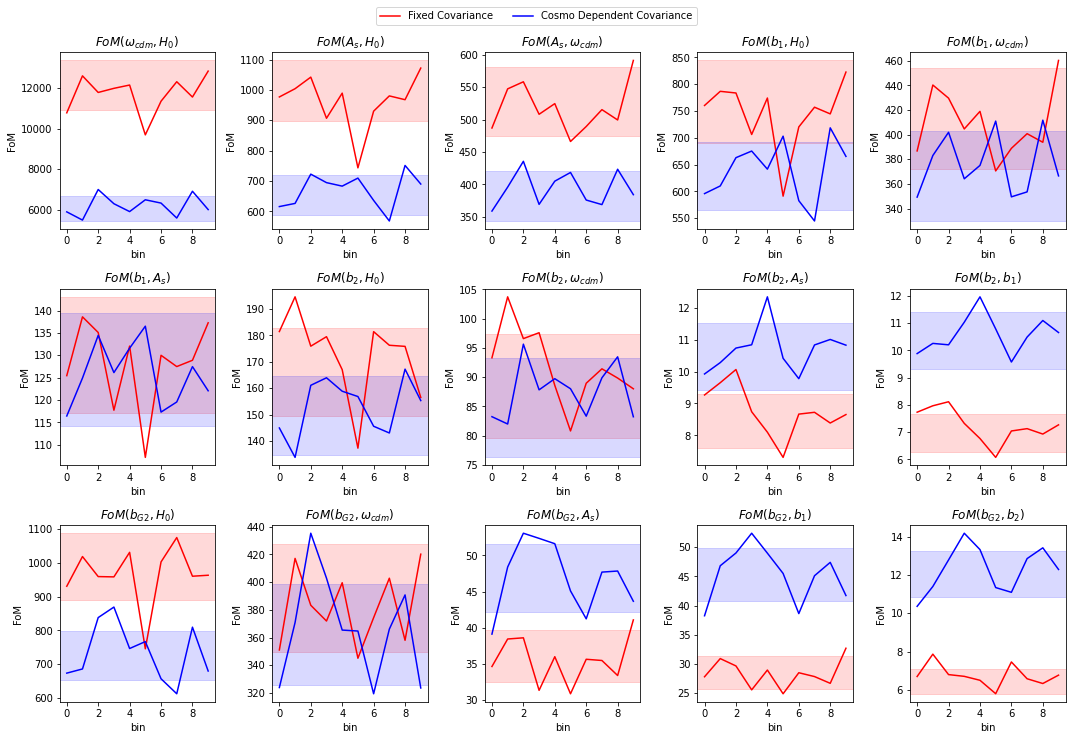

In [37]:
fig, axs = plt.subplots(3, 5, figsize=(15,10))
labels =  ["H_0", '\omega_{cdm}', 'A_s', 'b_1', 'b_2', "b_{G2}"]
num_bins = 10
idx = 0
ax_list = axs.ravel()
for i in range(6):
    for j in range(6):
        if j >= i:
            continue
        name1 = names_marg[i+2]
        name2 = names_marg[j+2]
        FoM_1, FoM_2, FoM_30 = FoM(name1, name2, num_bins)
        ax_list[idx].set_title(r"$FoM(" + labels[i] + ", " + labels[j] + ")$")
        l1 = ax_list[idx].plot(range(num_bins), FoM_1, c="red")
        l2 = ax_list[idx].plot(range(num_bins), FoM_2, c="blue")

        h1 = ax_list[idx].axhspan(FoM_30[0]*0.9, FoM_30[0]*1.1, color="red", alpha=0.15)
        h2 = ax_list[idx].axhspan(FoM_30[1]*0.9, FoM_30[1]*1.1, color="blue", alpha=0.15)
        
        #ax[0].set_yscale("log")
        ax_list[idx].set_xlabel("bin")
        ax_list[idx].set_xlabel("bin")
        ax_list[idx].set_ylabel("FoM")

        idx+= 1
        
fig.legend([l1, l2], labels=["Fixed Covariance", "Cosmo Dependent Covariance"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.03))
plt.tight_layout()

## Multinest Code

  analysing data from /home/joeadamo/Research/CovNet/chains/MontePython/montepython-data/multinest/NS/multinest-.txt


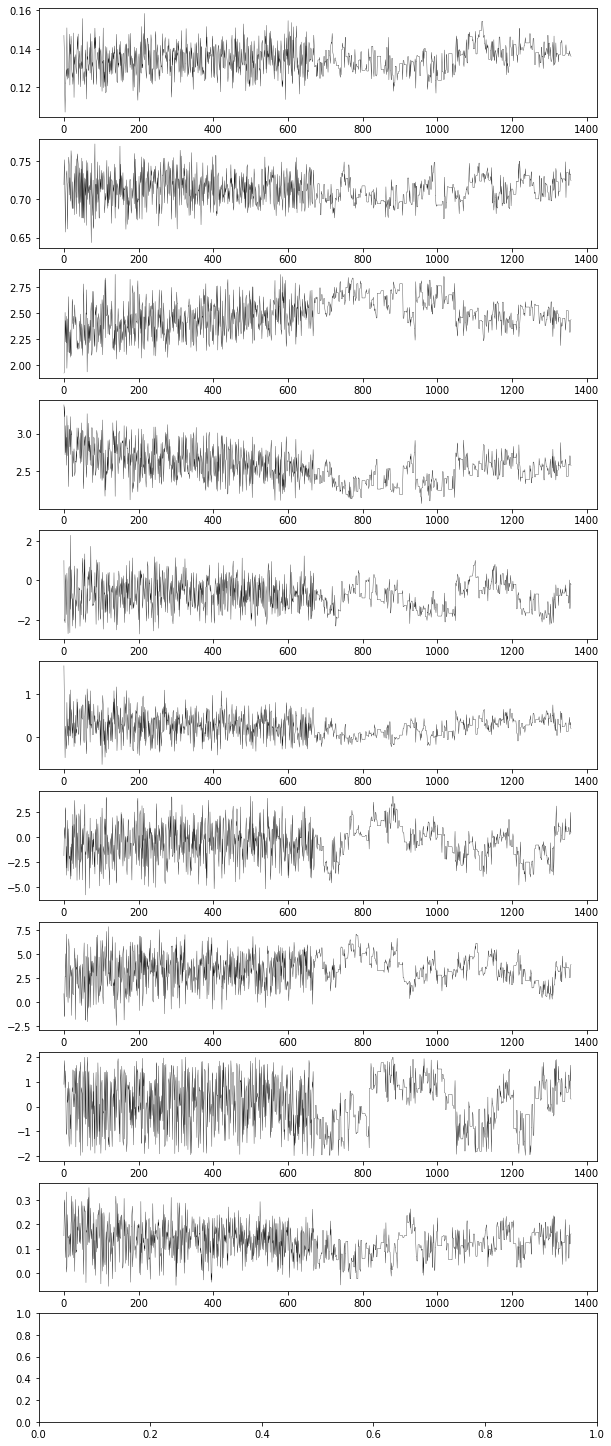

In [9]:
# lets analyse the results
import pymultinest
NDIM=10
multinest_dir = "/home/joeadamo/Research/CovNet/chains/MontePython/montepython-data/multinest/NS/multinest-"

a_T0 = pymultinest.Analyzer(n_params = 10, outputfiles_basename=multinest_dir)
#a_no_T0 = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=chains_dir+prefix[1])
#s = a.get_stats()

# This takes the end of the chain calculated by multinest
chain_Mult_T0 = a_T0.get_equal_weighted_posterior()
#chain_Mult_no_T0 = a_no_T0.get_equal_weighted_posterior()

#chain_Mult_T0[:,3] = np.exp(chain_Mult_T0[:,3]) / 1e10
#chain_Mult_no_T0[:,3] = np.exp(chain_Mult_no_T0[:,3]) / 1e10
fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
for i in range(NDIM):
    ax[i].plot(chain_Mult_T0[:,i], 'k-', lw=0.3)
#fig, ax = plt.subplots(NDIM+1,1,figsize=(10, 2.5 * NDIM+1))
#for i in range(7):
#    ax[i].plot(chain_Mult_no_T0[:,i], 'k-', lw=0.3)
plt.show()

In [10]:
N_BURN_IN = 10
Omega_b = 0.048206; h = cosmo_fid[0] / 100.
Omega_m = 0.307115

#samples_fixed = chain_fixed[N_BURN_IN:, :].reshape((-1,NDIM))
# look into what the consensus is for using the T0 term <- can look at this in the simulation case as well
samples_1 = chain_Mult_T0[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
#samples_2 = chain_Mult_no_T0[N_BURN_IN:, :NDIM].reshape((-1,NDIM))
plot_cosmo_contours([samples_1], [ "Fixed Covariance"], 10)
#plot_cosmo_contours(samples_2, samples_2, [ "No T0 term", "No T0 term"], 6

TypeError: plot_cosmo_contours() missing 1 required positional argument: 'num_plots'

100%|███████████████████████████████████████| 2159/2159 [11:32<00:00,  3.12it/s]


Removed no burn in


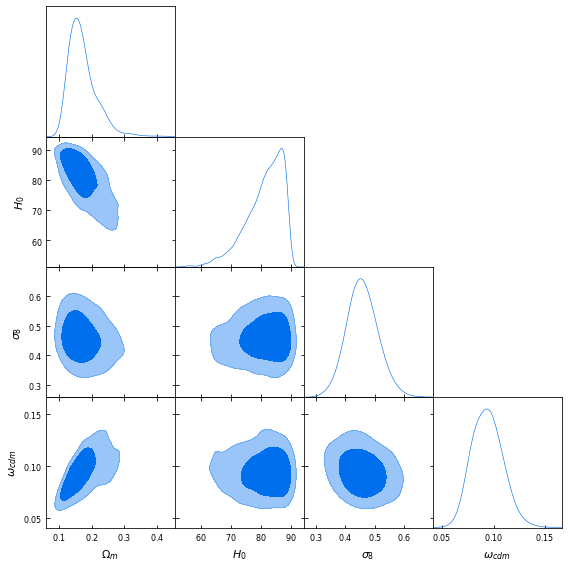

In [34]:
plot_derived_contours([samples_1], [ "Fixed Covariance"], True)

In [ ]:
# print("\tFull Covariance\t\t\tNo T0")

# # print(str(parameters[0])+":\t {:0.2f} +- {:0.2f}\t\t\t {:0.2f} +- {:0.2f}".format(np.mean(chain_fixed[:,0]), np.std(chain_fixed[:,0]), np.mean(chain_no_T0[:,0]), np.std(chain_no_T0[:,0])))
# # print(str(parameters[1])+":\t {:0.4f} +- {:0.4f}\t\t {:0.4f} +- {:0.4f}".format(np.mean(chain_fixed[:,1]), np.std(chain_fixed[:,1]), np.mean(chain_no_T0[:,1]), np.std(chain_no_T0[:,1])))
# # print(str(parameters[2])+":\t {:0.5f} +- {:0.5f}\t\t {:0.5f} +- {:0.5f}".format(np.mean(chain_fixed[:,2]), np.std(chain_fixed[:,2]), np.mean(chain_no_T0[:,2]), np.std(chain_no_T0[:,2])))
# # print(str(parameters[3])+":\t {:0.2e} +- {:0.2e}\t\t {:0.2e} +- {:0.2e}".format(np.mean(chain_fixed[:,3]), np.std(chain_fixed[:,3]), np.mean(chain_no_T0[:,3]), np.std(chain_no_T0[:,3])))
# # print(str(parameters[4])+":\t {:0.3f} +- {:0.2f}\t\t\t {:0.3f} +- {:0.3f}".format(np.mean(chain_fixed[:,4]), np.std(chain_fixed[:,4]), np.mean(chain_no_T0[:,4]), np.std(chain_no_T0[:,4])))
# # print(str(parameters[5])+":\t {:0.3f} +- {:0.2f}\t\t\t {:0.3f} +- {:0.3f}".format(np.mean(chain_fixed[:,5]), np.std(chain_fixed[:,5]), np.mean(chain_no_T0[:,5]), np.std(chain_no_T0[:,5])))

# for i in range(6):
#     print("shift: {:0.3f} sigma".format((abs(np.mean(chain_fixed[:,i]) - np.mean(chain_no_T0[:,i])) / np.std(chain_fixed[:,i]))))

took 1.491 s
0.8295181125359163


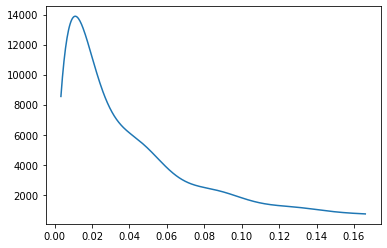

In [20]:
k_mpc = np.linspace(0.005,0.245,400) * 0.6777 # in 1/Mpc
cosmo = Class()
z_pk = 0.61
cosmo.set({'A_s':2.207e-9,
           'n_s':0.9645,
           'tau_reio':0.052,
           'omega_b':0.02215,
           'omega_cdm':0.1190,
           'h':0.6777,
           'YHe':0.2425,
           'N_ur':2.0328,
           'N_ncdm':1,
           'm_ncdm':0.06,
           'T_ncdm': 0.71611,
           'z_pk':z_pk
          })  
#Set additional CLASS-PT settings
cosmo.set({'output':'mPk',
           'non linear':'None',
           #'IR resummation':'No',
           #'Bias tracers':'Yes',
           'FFTLog mode':'FAST',
           'cb':'Yes', # use CDM+baryon spectra
           #'RSD':'No',
           #'AP':'No', # Alcock-Paczynski effect
           'Omfid':'0.31', # fiducial Omega_m
           #'PNG':'No' # single-field inflation PNG
         })
t1 = time.time()
cosmo.compute()
print("took {:0.3f} s".format(time.time() - t1))

pk_lin = np.asarray([cosmo.pk_lin(kk,0.61) for kk in k_mpc]) # in Mpc^3
pk_lin *= 0.6777**3
sigma8 = cosmo.sigma8()
print(sigma8)
plt.plot(k_mpc, pk_lin)